In [8]:
import os
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/clarabottinelli/Documents/GitHub/DSML/notebooks


In [10]:
import os
import pandas as pd

# Load the air quality merged data
aq_df = pd.read_csv("../data/processed/AQ_merged_data_export_2.csv")

In [2]:
# Set up output directory for figures in the DSML/figures/EDA folder (relative to project root)
figures_path = os.path.abspath(os.path.join("..", "figures", "EDA"))

In [12]:
# Display basic info
print("Shape:", aq_df.shape)
print("Columns:", aq_df.columns.tolist())
print("\nHead:")
print(aq_df.head())

# Summary statistics
print("\nSummary statistics:")
print(aq_df.describe(include='all'))

# Check for missing values
print("\nMissing values per column:")
print(aq_df.isnull().sum())

Shape: (18748456, 9)
Columns: ['Country', 'Samplingpoint', 'Pollutant', 'Start', 'End', 'Value', 'Unit', 'AggType', 'Notation']

Head:
  Country           Samplingpoint  Pollutant                Start  \
0      NO  NO/SPO_NO0073A_38_1785         38  2019-01-01 00:00:00   
1      NO  NO/SPO_NO0073A_38_1785         38  2019-01-01 01:00:00   
2      NO  NO/SPO_NO0073A_38_1785         38  2019-01-01 02:00:00   
3      NO  NO/SPO_NO0073A_38_1785         38  2019-01-01 03:00:00   
4      NO  NO/SPO_NO0073A_38_1785         38  2019-01-01 04:00:00   

                   End   Value    Unit AggType Notation  
0  2019-01-01 01:00:00 -9900.0  ug.m-3    hour     PM10  
1  2019-01-01 02:00:00 -9900.0  ug.m-3    hour     PM10  
2  2019-01-01 03:00:00 -9900.0  ug.m-3    hour     PM10  
3  2019-01-01 04:00:00 -9900.0  ug.m-3    hour     PM10  
4  2019-01-01 05:00:00 -9900.0  ug.m-3    hour     PM10  

Summary statistics:
         Country           Samplingpoint     Pollutant                Start  \
co

In [13]:
# Add "Group" column for comparison
aq_df['Group'] = aq_df['Country'].apply(lambda x: 'NO' if x == 'NO' else 'Other')

# Grouped summary
pollutant_summary = (
    aq_df.groupby(['Group', 'Notation'])['Value']
    .agg(['count', 'mean', 'median', 'std', 'min', 'max'])
    .reset_index()
)

pollutant_summary

,Group,Notation,count,mean,median,std,min,max
0,NO,CO2,89389,-157.964910,41.153030,1.393974e+03,-9.900000e+03,3.983997e+02
1,NO,NO,938397,-34066.986080,12.000000,2.410000e+07,-1.167965e+10,1.183894e+10
2,NO,NO2,786426,-245.900389,22.308551,1.640109e+03,-9.900000e+03,1.042291e+05
3,NO,NOX as NO2,873203,1280.442538,5.954091,1.457190e+06,-6.187390e+08,9.471632e+08
4,NO,PM10,740197,-284.128630,9.503636,1.766650e+03,-9.900000e+03,2.417772e+05
5,NO,PM2.5,740197,-239.218071,38.007242,1.854041e+03,-9.900000e+03,4.736647e+05
6,Other,CO2,1575665,44.961200,50.100000,7.651381e+01,-9.990000e+02,2.597650e+02
7,Other,NO,2868948,11.174734,14.200000,8.195954e+01,-9.990000e+02,1.068830e+03
8,Other,NO2,4044095,20.317907,18.800000,6.339312e+01,-9.990000e+02,4.163000e+02
9,Other,NOX as NO2,2005366,-0.603059,6.810724,9.732528e+01,-9.990000e+02,1.238700e+03


In [14]:
# Create hourly mean value
aq_df['hour'] = pd.to_datetime(aq_df['Start']).dt.hour

hourly_compare = (
    aq_df.groupby(['Group', 'Notation', 'hour'])['Value']
    .mean()
    .reset_index()
)

hourly_compare

,Group,Notation,hour,Value
0,NO,CO2,0,-160.762975
1,NO,CO2,1,-163.205249
2,NO,CO2,2,-179.321106
3,NO,CO2,3,-163.668800
4,NO,CO2,4,-174.726624
...,...,...,...,...
283,Other,PM2.5,19,40.399794
284,Other,PM2.5,20,37.804542
285,Other,PM2.5,21,35.724445
286,Other,PM2.5,22,32.581283


In [15]:
# Count values that are clearly invalid (e.g., -9900 is used in your dataset)
aq_df['is_invalid'] = aq_df['Value'] < -1000

invalid_stats = (
    aq_df.groupby(['Country', 'Notation'])['is_invalid']
    .mean()
    .reset_index()
    .rename(columns={'is_invalid': 'InvalidValueRate'})
    .sort_values(by='InvalidValueRate', ascending=False)
)

invalid_stats

,Country,Notation,InvalidValueRate
26,NO,PM2.5,0.031752
25,NO,PM10,0.031697
23,NO,NO2,0.027840
24,NO,NOX as NO2,0.020461
21,NO,CO2,0.020058
22,NO,NO,0.018394
0,AT,CO2,0.000000
1,AT,NO,0.000000
30,SE,NOX as NO2,0.000000
29,SE,NO2,0.000000


In [16]:
aq_df['Year'] = pd.to_datetime(aq_df['Start']).dt.year

year_coverage = (
    aq_df.groupby(['Country'])['Year']
    .agg(['min', 'max', 'nunique'])
    .reset_index()
    .rename(columns={'min': 'StartYear', 'max': 'EndYear', 'nunique': 'YearCount'})
)

year_coverage

,Country,StartYear,EndYear,YearCount
0,AT,2008,2023,12
1,CH,2014,2023,10
2,DK,2013,2023,9
3,NL,2013,2023,11
4,NO,2013,2023,11
5,SE,2013,2023,11


In [17]:
station_density = aq_df.groupby('Country')['Samplingpoint'].nunique().reset_index()
station_density.columns = ['Country', 'UniqueStations']
station_density

,Country,UniqueStations
0,AT,55
1,CH,28
2,DK,13
3,NL,49
4,NO,54
5,SE,63


In [29]:
for col in world.columns:
    print(col)

featurecla
scalerank
LABELRANK
SOVEREIGNT
SOV_A3
ADM0_DIF
LEVEL
TYPE
TLC
ADMIN
ADM0_A3
GEOU_DIF
GEOUNIT
GU_A3
SU_DIF
SUBUNIT
SU_A3
BRK_DIFF
NAME
NAME_LONG
BRK_A3
BRK_NAME
BRK_GROUP
ABBREV
POSTAL
FORMAL_EN
FORMAL_FR
NAME_CIAWF
NOTE_ADM0
NOTE_BRK
NAME_SORT
NAME_ALT
MAPCOLOR7
MAPCOLOR8
MAPCOLOR9
MAPCOLOR13
POP_EST
POP_RANK
POP_YEAR
GDP_MD
GDP_YEAR
ECONOMY
INCOME_GRP
FIPS_10
ISO_A2
ISO_A2_EH
ISO_A3
ISO_A3_EH
ISO_N3
ISO_N3_EH
UN_A3
WB_A2
WB_A3
WOE_ID
WOE_ID_EH
WOE_NOTE
ADM0_ISO
ADM0_DIFF
ADM0_TLC
ADM0_A3_US
ADM0_A3_FR
ADM0_A3_RU
ADM0_A3_ES
ADM0_A3_CN
ADM0_A3_TW
ADM0_A3_IN
ADM0_A3_NP
ADM0_A3_PK
ADM0_A3_DE
ADM0_A3_GB
ADM0_A3_BR
ADM0_A3_IL
ADM0_A3_PS
ADM0_A3_SA
ADM0_A3_EG
ADM0_A3_MA
ADM0_A3_PT
ADM0_A3_AR
ADM0_A3_JP
ADM0_A3_KO
ADM0_A3_VN
ADM0_A3_TR
ADM0_A3_ID
ADM0_A3_PL
ADM0_A3_GR
ADM0_A3_IT
ADM0_A3_NL
ADM0_A3_SE
ADM0_A3_BD
ADM0_A3_UA
ADM0_A3_UN
ADM0_A3_WB
CONTINENT
REGION_UN
SUBREGION
REGION_WB
NAME_LEN
LONG_LEN
ABBREV_LEN
TINY
HOMEPART
MIN_ZOOM
MIN_LABEL
MAX_LABEL
LABEL_X
LABEL_Y
NE_ID
WIKIDA

In [30]:
world['CONTINENT'].unique() 

array(['Oceania', 'Africa', 'North America', 'Asia', 'South America',
       'Europe', 'Seven seas (open ocean)', 'Antarctica'], dtype=object)

In [28]:
print(world['SUBREGION'].unique())

['Melanesia' 'Eastern Africa' 'Northern Africa' 'Northern America'
 'Central Asia' 'South-Eastern Asia' 'South America' 'Middle Africa'
 'Caribbean' 'Eastern Europe' 'Northern Europe' 'Seven seas (open ocean)'
 'Southern Africa' 'Central America' 'Western Europe' 'Western Africa'
 'Western Asia' 'Eastern Asia' 'Southern Asia' 'Southern Europe'
 'Australia and New Zealand' 'Antarctica']


Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_TR', 'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT',
       'FCLASS_NL', 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'geometry'],
      dtype='object', length=169)


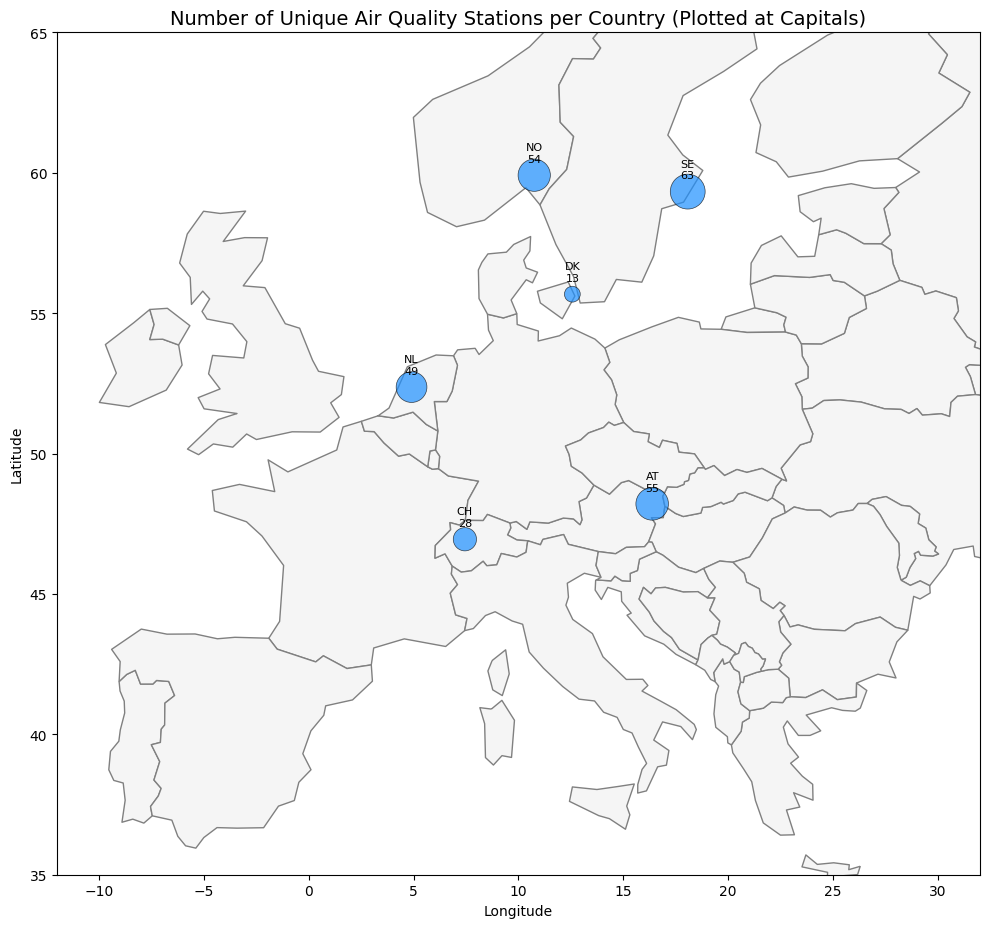

Saved: c:\Users\jskif\OneDrive - epfl.ch\Documents\SMT\DSML\DSML\figures\EDA\station_density_map.png


In [31]:
import matplotlib.pyplot as plt
import os

# Use the correct figures path (relative to project root, not notebook location)
figures_path = os.path.abspath(os.path.join("..", "figures", "EDA"))

# Plot the map of Europe
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-12, 32, 35, 65], crs=ccrs.PlateCarree())  # Europe bounds

# Merge coordinates into station_density
station_density['lat'] = station_density['Country'].map(lambda c: capital_coords.get(c, (None, None))[0])
station_density['lon'] = station_density['Country'].map(lambda c: capital_coords.get(c, (None, None))[1])
station_density = station_density.dropna(subset=['lat', 'lon'])

# Plot: stations per capital on a map of Europe
world = gpd.read_file('../data/raw/naturalearth/ne_110m_admin_0_countries.shp')
print(world.columns)  # Add this line to see available columns
# Try one of the following, depending on your shapefile:
europe = world[world['CONTINENT'] == 'Europe']

fig, ax = plt.subplots(figsize=(10, 10))
europe.plot(ax=ax, color='whitesmoke', edgecolor='gray')

# Plot circles for each capital
scatter = ax.scatter(
    station_density['lon'], station_density['lat'],
    s=station_density['UniqueStations'] * 10,  # Scale for visibility
    color='dodgerblue', alpha=0.7, edgecolor='black', linewidth=0.5,
    transform=ccrs.PlateCarree()
)

# Annotate with country code and value
for _, row in station_density.iterrows():
    ax.text(row['lon'], row['lat'] + 0.4, f"{row['Country']}\n{int(row['UniqueStations'])}",
            fontsize=8, ha='center', va='bottom', transform=ccrs.PlateCarree())

ax.set_title("Number of Unique Air Quality Stations per Country (Plotted at Capitals)", fontsize=14)
plt.tight_layout()
fig_path = os.path.join(figures_path, "station_density_map.png")
plt.savefig(fig_path, dpi=150)
plt.show()
print(f"Saved: {fig_path}")

### cleaning Norway data

In [ ]:
import numpy as np

# Replace all negative values in 'Value' with 0 (noise at low concentrations)
aq_df['Value'] = aq_df['Value'].apply(lambda x: max(x, 0) if pd.notnull(x) else x)

# Optional: Drop rows with NaN values after cleaning (or you can impute or keep them as is)
aq_df_clean = aq_df.dropna(subset=['Value'])

# Now you can run your hourly pattern grouping and plotting on aq_df_clean
hourly_pattern = (
    aq_df_clean.groupby(['Notation', 'Country', 'hour'])['Value']
    .mean()
    .reset_index()
)

In [ ]:
import numpy as np

# Define invalid or suspicious negative thresholds per pollutant if needed
# For a quick global fix, just remove obviously invalid negative values below zero for air pollutants,
# but you might want pollutant-specific logic for CO2 or NOX if valid negatives exist.

# Step 1: Define a reasonable minimum threshold for valid pollutant values
# For example, no pollutant concentration should be below 0 (or a small negative tolerance for sensor noise)
min_valid_value = 0

# Step 2: Clean the data for Norway only
mask_no = (aq_df['Country'] == 'NO')

# Remove invalid values for Norway by setting them to NaN or filtering them out
aq_df.loc[mask_no & (aq_df['Value'] < min_valid_value), 'Value'] = np.nan

# Optional: Drop rows with NaN values after cleaning (or you can impute or keep them as is)
aq_df_clean = aq_df.dropna(subset=['Value'])

# Now you can run your hourly pattern grouping and plotting on aq_df_clean
hourly_pattern = (
    aq_df_clean.groupby(['Notation', 'Country', 'hour'])['Value']
    .mean()
    .reset_index()
)

In [ ]:
import numpy as np

# Step 1: Define pollutant-specific thresholds
thresholds = {
    'NO': {'min': 0, 'max': 223},
    'NOX as NO2': {'min': 0, 'max': 100},
    'CO2': {'min': 0, 'max': 1000},  # Adjust if needed
    'NO2': {'min': 0, 'max': 500},
    'PM10': {'min': 0, 'max': 500},
    'PM2.5': {'min': 0, 'max': 500}
}

# Step 2: Define known invalid placeholders
invalid_placeholders = [-888.0, -999.0]

# Step 3: Replace known invalid placeholders with NaN
aq_df['Value'] = aq_df['Value'].replace(invalid_placeholders, np.nan)

# Step 4: Apply pollutant-specific filtering for Norway and Netherlands
for country in ['NO', 'NL']:
    for pollutant, bounds in thresholds.items():
        mask = (aq_df['Country'] == country) & (aq_df['Notation'] == pollutant)
        aq_df.loc[mask & ((aq_df['Value'] < bounds['min']) | (aq_df['Value'] > bounds['max'])), 'Value'] = np.nan

# Optional: Drop NaNs for analysis (or impute if needed)
aq_df_clean = aq_df.dropna(subset=['Value'])

# Step 5: Compute hourly averages for cleaned data
hourly_pattern = (
    aq_df_clean.groupby(['Notation', 'Country', 'hour'])['Value']
    .mean()
    .reset_index()
)

## Daily analysis 

### 24h average

In [ ]:
# Check if AQ_daily_avg_per_country exists in data/processed folder and skip step below if it does
aq_daily_avg_path = "../data/processed/AQ_daily_avg_per_country.csv"    
if not os.path.exists(aq_daily_avg_path):
    # Compute daily averages for each pollutant per country
    # Create a copy of aq_data
    aq_df_clean = aq_df_clean.copy()
    aq_daily_avg_per_country = (
        aq_df_clean.groupby(['Country', 'Notation', 'Start'])['Value']
        .mean()
        .reset_index()
        .rename(columns={'Value': 'DailyAverageValue'})
    )

    # Save the daily averages to a CSV file
    aq_daily_avg_per_country.to_csv(aq_daily_avg_path, index=False)
else:
    # Load the daily averages from the CSV file
    aq_daily_avg_per_country = pd.read_csv(aq_daily_avg_path)
    daily_avg_per_country = aq_daily_avg_per_country
    
daily_avg_per_country

,Country,Notation,Start,DailyAverageValue
0,AT,CO2,2013-01-01 00:00:00,23.796000
1,AT,CO2,2013-01-01 01:00:00,22.163000
2,AT,CO2,2013-01-01 02:00:00,26.623600
3,AT,CO2,2013-01-01 03:00:00,36.410000
4,AT,CO2,2013-01-01 04:00:00,38.463600
...,...,...,...,...
2568318,SE,PM2.5,2023-12-31 18:00:00,24.903723
2568319,SE,PM2.5,2023-12-31 19:00:00,22.336505
2568320,SE,PM2.5,2023-12-31 20:00:00,16.303473
2568321,SE,PM2.5,2023-12-31 21:00:00,15.766884


In [ ]:
#summary statistics of daily average values
daily_avg_per_country.describe()

,DailyAverageValue
count,2.568323e+06
mean,2.396056e+01
std,2.035121e+01
min,-1.850000e+00
25%,7.913000e+00
50%,1.754700e+01
75%,3.536204e+01
max,8.573667e+01


In [ ]:
#getting rid of outliers
Q1 = daily_avg_per_country['DailyAverageValue'].quantile(0.25)
Q3 = daily_avg_per_country['DailyAverageValue'].quantile(0.75)

IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

AQ_daily_avg_per_country = daily_avg_per_country[
    (daily_avg_per_country['DailyAverageValue'] >= lower_bound) &
    (daily_avg_per_country['DailyAverageValue'] <= upper_bound)
]
# Save the cleaned data to a new CSV file in data/processed
output_file = "../data/processed/AQ_daily_avg_per_country.csv"
AQ_daily_avg_per_country.to_csv(output_file, index=False)

daily_avg_per_country

,Country,Notation,Start,DailyAverageValue
0,AT,CO2,2013-01-01 00:00:00,23.796000
1,AT,CO2,2013-01-01 01:00:00,22.163000
2,AT,CO2,2013-01-01 02:00:00,26.623600
3,AT,CO2,2013-01-01 03:00:00,36.410000
4,AT,CO2,2013-01-01 04:00:00,38.463600
...,...,...,...,...
2568318,SE,PM2.5,2023-12-31 18:00:00,24.903723
2568319,SE,PM2.5,2023-12-31 19:00:00,22.336505
2568320,SE,PM2.5,2023-12-31 20:00:00,16.303473
2568321,SE,PM2.5,2023-12-31 21:00:00,15.766884


In [ ]:
import os
import matplotlib.pyplot as plt

# Set up output directory
output_dir = "figures/EDA"
os.makedirs(output_dir, exist_ok=True)

# Filter data for a specific pollutant (e.g., NO2)
# Options in 'Notation' column: ['CO2', 'NO', 'NO2', 'NOX as NO2', 'PM10', 'PM2.5'], dtype=object
pollutant_to_visualize = 'NO2'
filtered_data = daily_avg_per_country[daily_avg_per_country['Notation'] == pollutant_to_visualize]

# Plot and save one figure per country
for country in filtered_data['Country'].unique():
    country_data = filtered_data[filtered_data['Country'] == country]
    plt.figure(figsize=(12, 6))
    plt.plot(country_data['Start'], country_data['DailyAverageValue'], label=country)
    plt.title(f'Daily Average Values of Pollutant (NO2) - {country}')
    plt.xlabel('Date')
    plt.ylabel('Daily Average Value')
    plt.legend(title='Country')
    plt.tight_layout()
    fig_path = os.path.join(output_dir, f"aq_daily_avg_NO2_{country}.png")
    plt.savefig(fig_path)
    plt.close()
    print(f"Saved: {fig_path}")

Saved: figures/EDA\aq_daily_avg_NO2_AT.png


### Day-time avg

In [ ]:
aq_df

,Country,Samplingpoint,Pollutant,Start,End,Value,Unit,AggType,Notation,Group,hour,is_invalid,Year
0,NO,NO/SPO_NO0073A_38_1785,38,2019-01-01 00:00:00,2019-01-01 01:00:00,NaN,ug.m-3,hour,PM10,NO,0,True,2019
1,NO,NO/SPO_NO0073A_38_1785,38,2019-01-01 01:00:00,2019-01-01 02:00:00,NaN,ug.m-3,hour,PM10,NO,1,True,2019
2,NO,NO/SPO_NO0073A_38_1785,38,2019-01-01 02:00:00,2019-01-01 03:00:00,NaN,ug.m-3,hour,PM10,NO,2,True,2019
3,NO,NO/SPO_NO0073A_38_1785,38,2019-01-01 03:00:00,2019-01-01 04:00:00,NaN,ug.m-3,hour,PM10,NO,3,True,2019
4,NO,NO/SPO_NO0073A_38_1785,38,2019-01-01 04:00:00,2019-01-01 05:00:00,NaN,ug.m-3,hour,PM10,NO,4,True,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18748451,NL,NL/SPO-NL00003_00009_101,9,2023-12-31 19:00:00,2023-12-31 20:00:00,5.4933,ug.m-3,hour,PM2.5,Other,19,False,2023
18748452,NL,NL/SPO-NL00003_00009_101,9,2023-12-31 20:00:00,2023-12-31 21:00:00,4.9933,ug.m-3,hour,PM2.5,Other,20,False,2023
18748453,NL,NL/SPO-NL00003_00009_101,9,2023-12-31 21:00:00,2023-12-31 22:00:00,5.6933,ug.m-3,hour,PM2.5,Other,21,False,2023
18748454,NL,NL/SPO-NL00003_00009_101,9,2023-12-31 22:00:00,2023-12-31 23:00:00,5.3933,ug.m-3,hour,PM2.5,Other,22,False,2023


In [ ]:
aq_df['Start'] = pd.to_datetime(aq_df['Start'])

# Filter data for day-time values (08:00:00 to 20:00:00)
day_time_data = aq_df[
    (aq_df['Start'].dt.time >= pd.to_datetime('08:00:00').time()) &
    (aq_df['Start'].dt.time <= pd.to_datetime('20:00:00').time())
]

# Compute daily mean for each pollutant value for each country
daily_daytime_avg_per_country = (
    day_time_data.groupby(['Country', 'Notation', day_time_data['Start'].dt.date])['Value']
    .mean()
    .reset_index()
    .rename(columns={'Start': 'Date', 'Value': 'DailyDaytimeAverageValue'})
)

daily_daytime_avg_per_country

,Country,Notation,Date,DailyDaytimeAverageValue
0,AT,CO2,2013-01-01,37.768769
1,AT,CO2,2013-01-02,31.984354
2,AT,CO2,2013-01-03,52.990462
3,AT,CO2,2013-01-04,34.681677
4,AT,CO2,2013-01-05,50.368323
...,...,...,...,...
112157,SE,PM2.5,2023-12-27,35.641131
112158,SE,PM2.5,2023-12-28,43.123789
112159,SE,PM2.5,2023-12-29,77.024367
112160,SE,PM2.5,2023-12-30,31.481479


In [ ]:
#summary statistics
summary_stats = daily_daytime_avg_per_country['DailyDaytimeAverageValue'].describe()
print(summary_stats)

#remove outliers
Q1 = daily_daytime_avg_per_country['DailyDaytimeAverageValue'].quantile(0.25)
Q3 = daily_daytime_avg_per_country['DailyDaytimeAverageValue'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

daily_daytime_avg_per_country = daily_daytime_avg_per_country[
    (daily_daytime_avg_per_country['DailyDaytimeAverageValue'] >= lower_bound) &
    (daily_daytime_avg_per_country['DailyDaytimeAverageValue'] <= upper_bound)
]

daily_daytime_avg_per_country

count    112091.000000
mean         32.572232
std          32.358514
min          -0.487132
25%          10.807162
50%          22.742835
75%          44.743167
max         400.956016
Name: DailyDaytimeAverageValue, dtype: float64


,Country,Notation,Date,DailyDaytimeAverageValue
0,AT,CO2,2013-01-01,37.768769
1,AT,CO2,2013-01-02,31.984354
2,AT,CO2,2013-01-03,52.990462
3,AT,CO2,2013-01-04,34.681677
4,AT,CO2,2013-01-05,50.368323
...,...,...,...,...
112157,SE,PM2.5,2023-12-27,35.641131
112158,SE,PM2.5,2023-12-28,43.123789
112159,SE,PM2.5,2023-12-29,77.024367
112160,SE,PM2.5,2023-12-30,31.481479


In [ ]:
daily_daytime_avg_per_country.columns

Index(['Country', 'Notation', 'Date', 'DailyDaytimeAverageValue'], dtype='object')

In [ ]:
daily_daytime_avg_per_country['Notation'].unique()

array(['CO2', 'NO', 'NO2', 'NOX as NO2', 'PM10', 'PM2.5'], dtype=object)

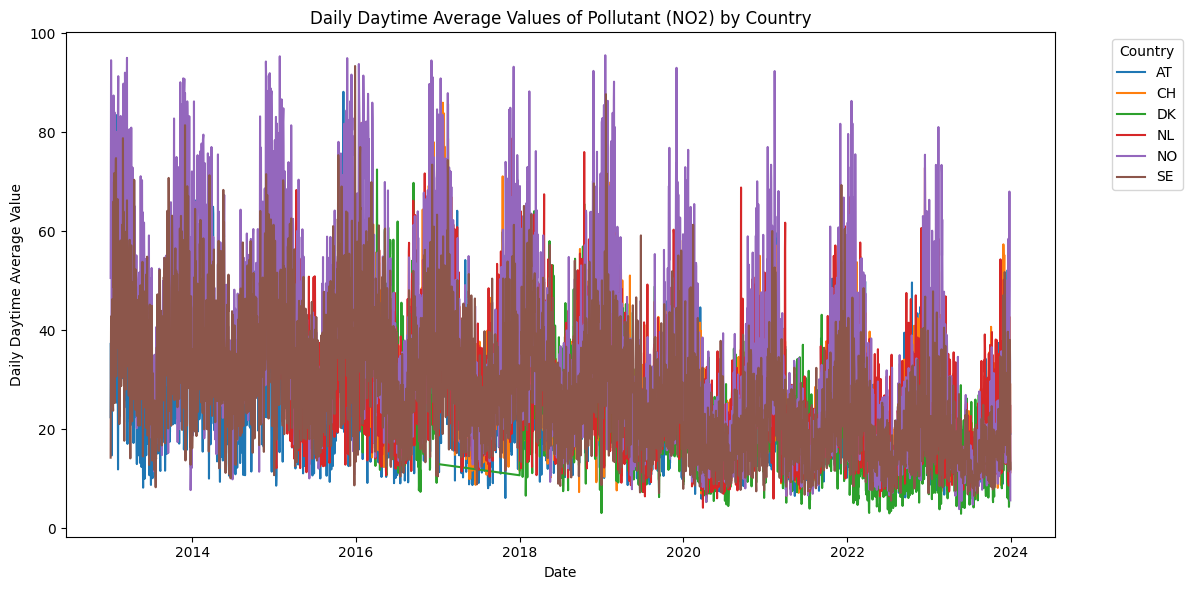

Saved: figures/EDA\aq_daily_avg_NO2_SE.png


In [ ]:
import matplotlib.pyplot as plt

# Filter data for a specific pollutant (e.g., NO2) for better visualization
pollutant_to_visualize = 'NO2'
filtered_data = daily_daytime_avg_per_country[daily_daytime_avg_per_country['Notation'] == pollutant_to_visualize]

# Plot the data
plt.figure(figsize=(12, 6))
for country in filtered_data['Country'].unique():
    country_data = filtered_data[filtered_data['Country'] == country]
    plt.plot(country_data['Date'], country_data['DailyDaytimeAverageValue'], label=country)

plt.title('Daily Daytime Average Values of Pollutant (NO2) by Country')
plt.xlabel('Date')
plt.ylabel('Daily Daytime Average Value')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
fig_path = os.path.join(output_dir, f"aq_daily_avg_NO2_{country}.png")
plt.savefig(fig_path)
plt.close()
print(f"Saved: {fig_path}")

/var/folders/c8/hcty8r1j2xj189pdz208fpnr0000gn/T/ipykernel_12385/2195508913.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_daytime_avg_per_country['DayOfWeek'] = pd.to_datetime(daily_daytime_avg_per_country['Date']).dt.dayofweek
/var/folders/c8/hcty8r1j2xj189pdz208fpnr0000gn/T/ipykernel_12385/2195508913.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_daytime_avg_per_country['IsWeekend'] = daily_daytime_avg_per_country['DayOfWeek'].isin([5, 6])  # Saturday and Sunday


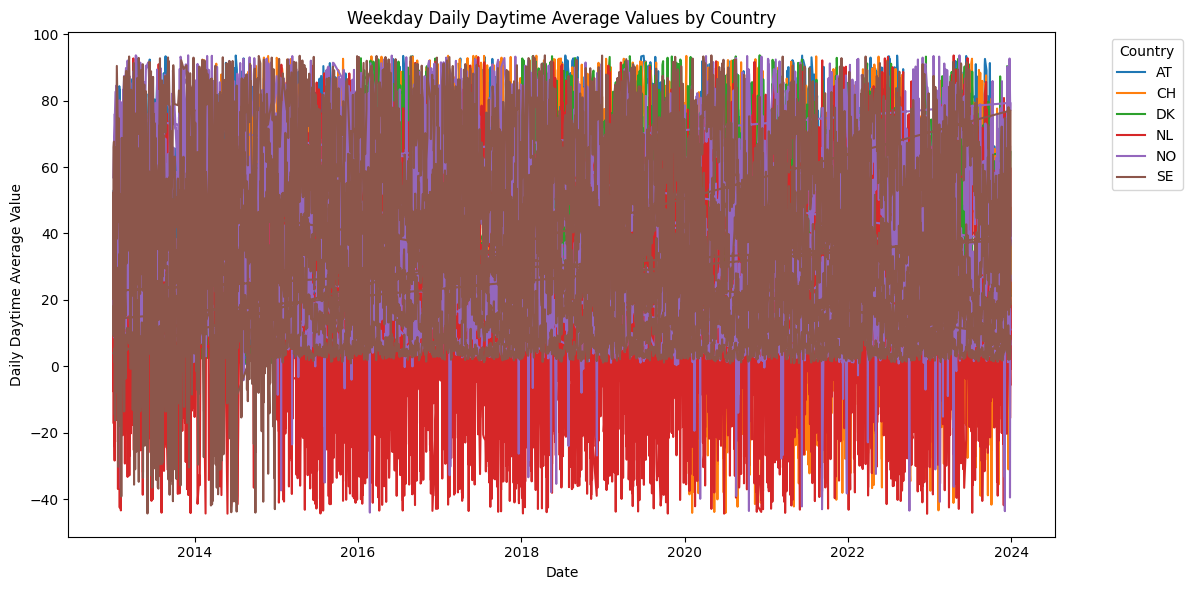

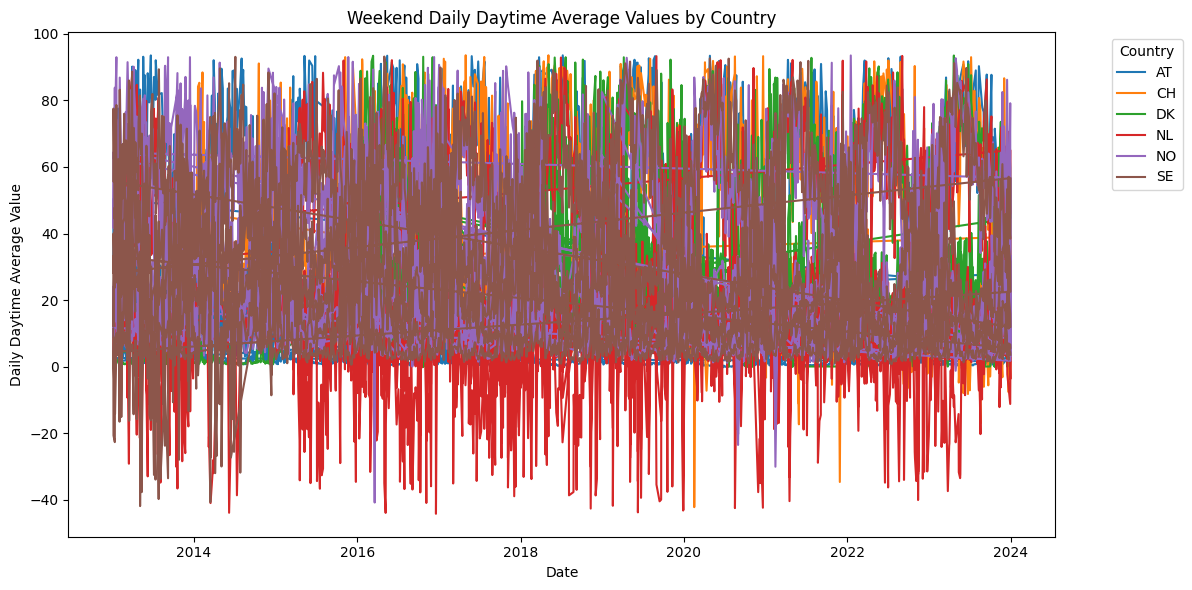

In [ ]:
# Add a column to indicate whether the day is a weekday or weekend
daily_daytime_avg_per_country['DayOfWeek'] = pd.to_datetime(daily_daytime_avg_per_country['Date']).dt.dayofweek
daily_daytime_avg_per_country['IsWeekend'] = daily_daytime_avg_per_country['DayOfWeek'].isin([5, 6])  # Saturday and Sunday

# Separate data for weekdays and weekends
weekday_data = daily_daytime_avg_per_country[~daily_daytime_avg_per_country['IsWeekend']]
weekend_data = daily_daytime_avg_per_country[daily_daytime_avg_per_country['IsWeekend']]

# Plot weekday data
plt.figure(figsize=(12, 6))
for country in weekday_data['Country'].unique():
    country_data = weekday_data[weekday_data['Country'] == country]
    plt.plot(country_data['Date'], country_data['DailyDaytimeAverageValue'], label=country)

plt.title('Weekday Daily Daytime Average Values by Country')
plt.xlabel('Date')
plt.ylabel('Daily Daytime Average Value')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot weekend data
plt.figure(figsize=(12, 6))
for country in weekend_data['Country'].unique():
    country_data = weekend_data[weekend_data['Country'] == country]
    plt.plot(country_data['Date'], country_data['DailyDaytimeAverageValue'], label=country)

plt.title('Weekend Daily Daytime Average Values by Country')
plt.xlabel('Date')
plt.ylabel('Daily Daytime Average Value')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Hourly air pollutant patterns (aggregated for all countries)

In [ ]:
aq_df

,Country,Samplingpoint,Pollutant,Start,End,Value,Unit,AggType,Notation
0,NO,NO/SPO_NO0073A_38_1785,38,2019-01-01 00:00:00,2019-01-01 01:00:00,-9900.0000,ug.m-3,hour,PM10
1,NO,NO/SPO_NO0073A_38_1785,38,2019-01-01 01:00:00,2019-01-01 02:00:00,-9900.0000,ug.m-3,hour,PM10
2,NO,NO/SPO_NO0073A_38_1785,38,2019-01-01 02:00:00,2019-01-01 03:00:00,-9900.0000,ug.m-3,hour,PM10
3,NO,NO/SPO_NO0073A_38_1785,38,2019-01-01 03:00:00,2019-01-01 04:00:00,-9900.0000,ug.m-3,hour,PM10
4,NO,NO/SPO_NO0073A_38_1785,38,2019-01-01 04:00:00,2019-01-01 05:00:00,-9900.0000,ug.m-3,hour,PM10
...,...,...,...,...,...,...,...,...,...
18748451,NL,NL/SPO-NL00003_00009_101,9,2023-12-31 19:00:00,2023-12-31 20:00:00,5.4933,ug.m-3,hour,PM2.5
18748452,NL,NL/SPO-NL00003_00009_101,9,2023-12-31 20:00:00,2023-12-31 21:00:00,4.9933,ug.m-3,hour,PM2.5
18748453,NL,NL/SPO-NL00003_00009_101,9,2023-12-31 21:00:00,2023-12-31 22:00:00,5.6933,ug.m-3,hour,PM2.5
18748454,NL,NL/SPO-NL00003_00009_101,9,2023-12-31 22:00:00,2023-12-31 23:00:00,5.3933,ug.m-3,hour,PM2.5


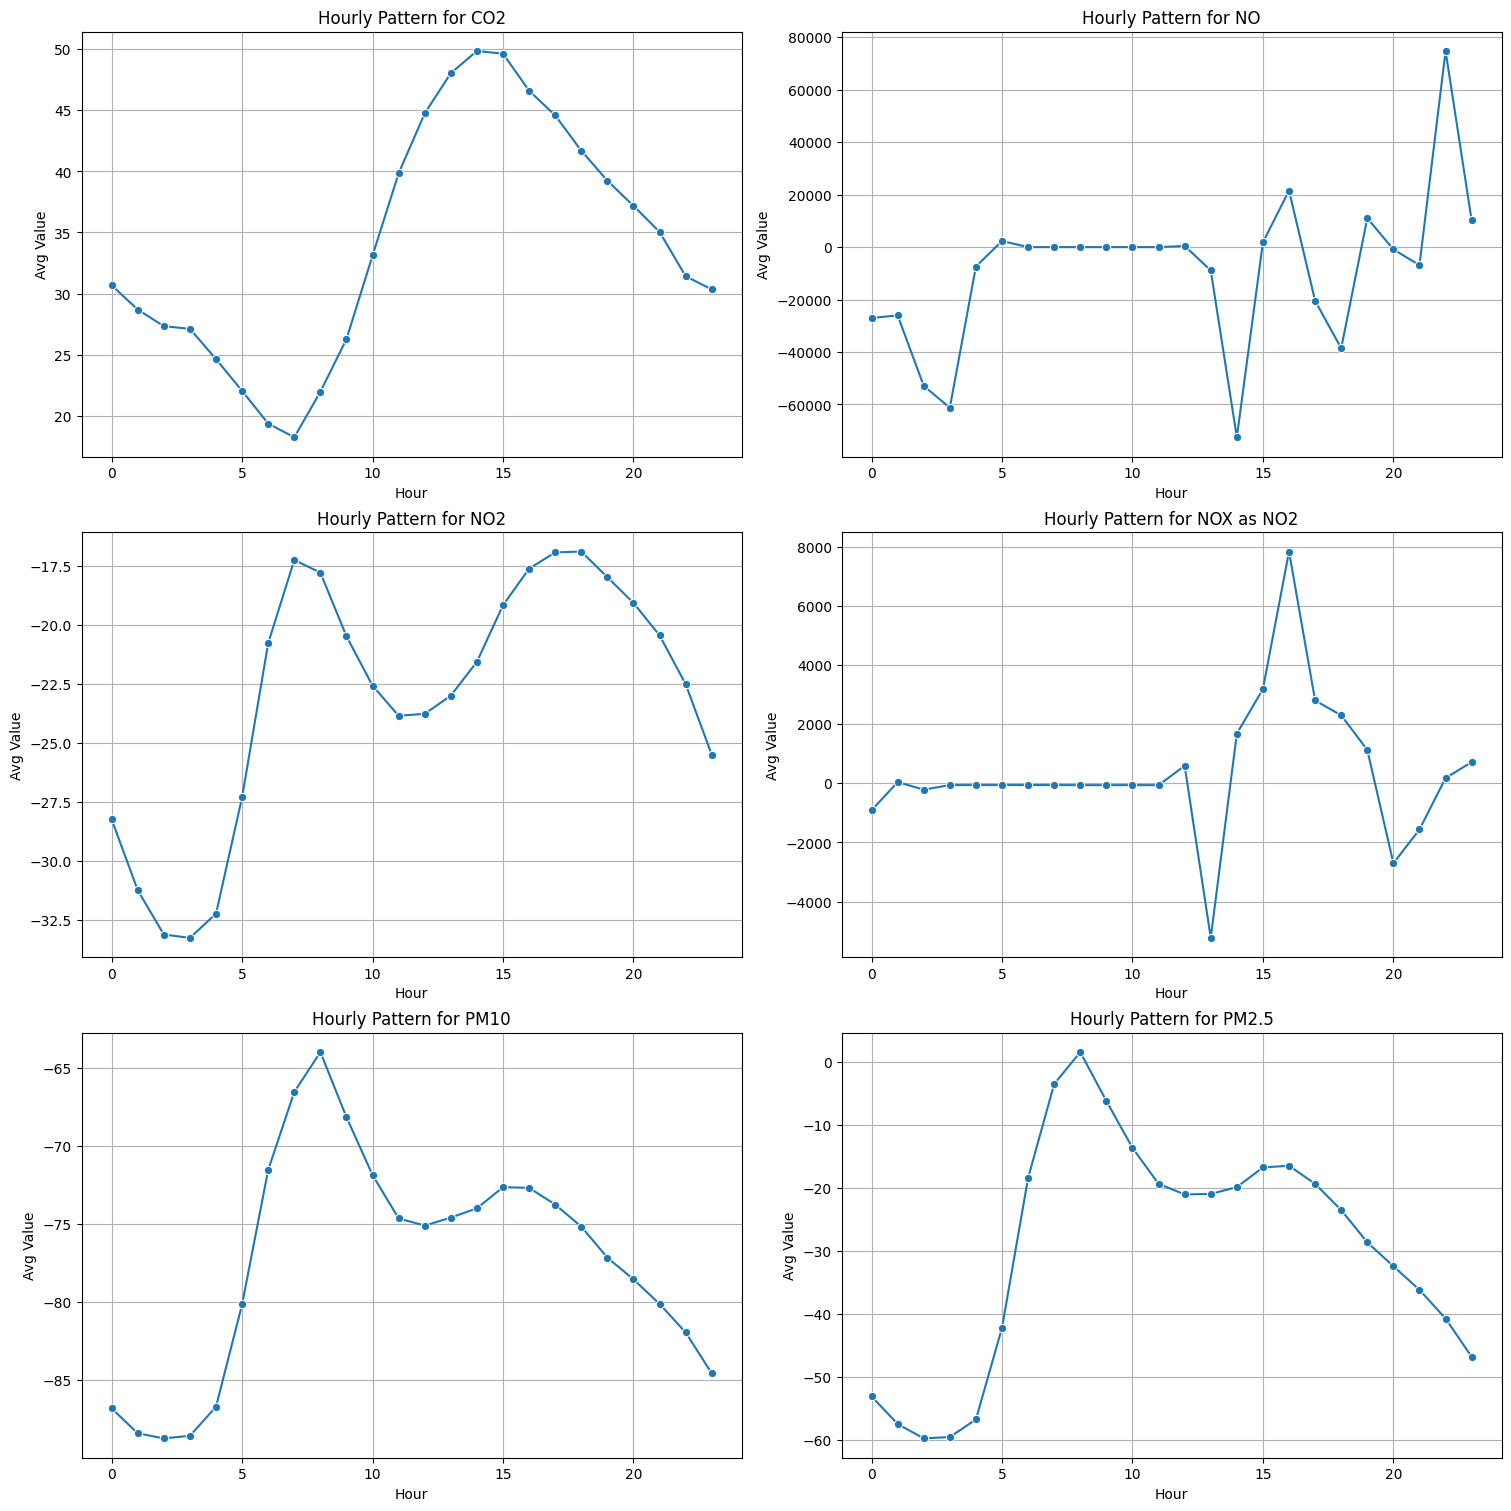

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure datetime format and extract hour column
aq_df['Start'] = pd.to_datetime(aq_df['Start'])
aq_df['hour'] = aq_df['Start'].dt.hour

# Compute average value by hour and pollutant notation
pollutant_hourly_pattern = (
    aq_df.groupby(['hour', 'Notation'])['Value']
    .mean()
    .reset_index()
)
unique_pollutants = pollutant_hourly_pattern['Notation'].unique()

# Define the number of rows and columns for the grid
ncols = 2
nrows = (len(unique_pollutants) + ncols - 1) // ncols  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows), constrained_layout=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each pollutant in a separate subplot
for ax, pollutant in zip(axes, unique_pollutants):
    data = pollutant_hourly_pattern[pollutant_hourly_pattern['Notation'] == pollutant]
    sns.lineplot(data=data, x='hour', y='Value', ax=ax, marker='o')
    ax.set_title(f"Hourly Pattern for {pollutant}")
    ax.set_xlabel("Hour")
    ax.set_ylabel("Avg Value")
    ax.grid(True)
    fig_path = os.path.join(output_dir, f"aq_hourly_pattern_per_pollutant.png")
    plt.savefig(fig_path)
    plt.close()
    print(f"Saved: {fig_path}")

# Hide any unused subplots
for ax in axes[len(unique_pollutants):]:
    ax.set_visible(False)

plt.show()

### Hourly air pollutant patterns (country breakdown)

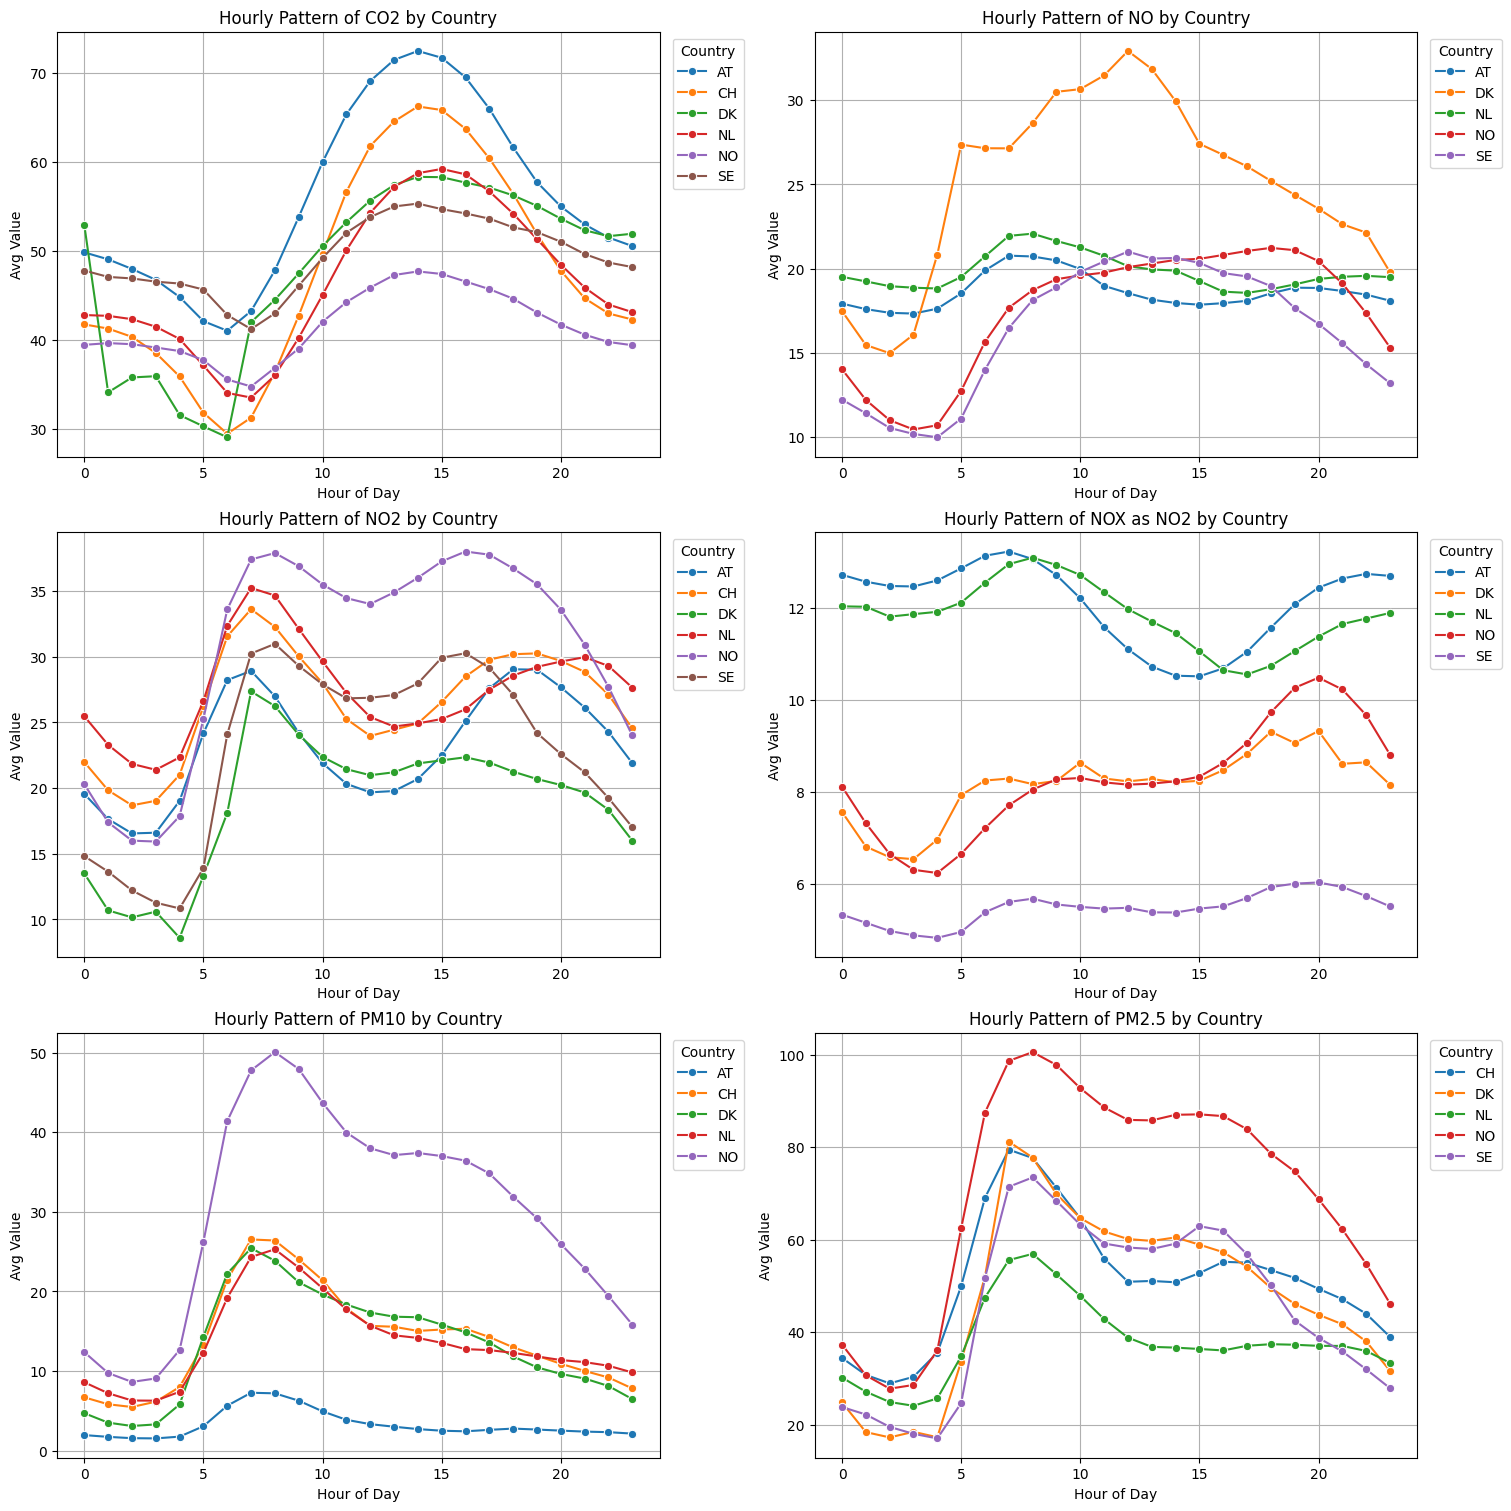

In [ ]:
# Group and compute average value per hour per pollutant per country --> inconsistent colors across countries, NO data needs cleaning
hourly_pattern = (
    aq_df_clean.groupby(['Notation', 'Country', 'hour'])['Value']
    .mean()
    .reset_index()
)

# Unique pollutants (Notation column)
unique_pollutants = hourly_pattern['Notation'].unique()

# Define the number of rows and columns for the grid
ncols = 2
nrows = (len(unique_pollutants) + ncols - 1) // ncols  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows), constrained_layout=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each pollutant, with a line per country
for ax, pollutant in zip(axes, unique_pollutants):
    data = hourly_pattern[hourly_pattern['Notation'] == pollutant]
    sns.lineplot(data=data, x='hour', y='Value', hue='Country', marker='o', ax=ax)
    ax.set_title(f"Hourly Pattern of {pollutant} by Country")
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Avg Value")
    ax.grid(True)
    ax.legend(title='Country', bbox_to_anchor=(1.01, 1), loc='upper left')
    fig_path = os.path.join(output_dir, f"aq_hourly_pattern_{pollutant}_by_country.png")
    plt.savefig(fig_path)
    plt.close()
    print(f"Saved: {fig_path}")

# Hide any unused subplots
for ax in axes[len(unique_pollutants):]:
    ax.set_visible(False)

plt.show()


In [ ]:
# Add "Group" column for comparison
aq_df['Group'] = aq_df['Country'].apply(lambda x: 'NL' if x == 'NL' else 'Other')

# Grouped summary
pollutant_summary = (
    aq_df.groupby(['Group', 'Notation'])['Value']
    .agg(['count', 'mean', 'median', 'std', 'min', 'max'])
    .reset_index()
)

pollutant_summary

,Group,Notation,count,mean,median,std,min,max
0,NL,CO2,262944,23.420553,46.300000,145.850260,-888.0,215.900000
1,NL,NO,631080,-8.919925,16.900000,159.424686,-888.0,636.100000
2,NL,NO2,867768,13.690029,22.200000,113.238423,-888.0,416.300000
3,NL,NOX as NO2,438240,-22.584442,8.600000,172.582444,-888.0,945.600000
4,NL,PM10,859008,-0.621349,3.400000,112.881773,-888.0,794.500000
5,NL,PM2.5,482064,25.110467,23.913300,116.289561,-888.0,1323.740000
6,Other,CO2,1400163,48.791473,50.179000,50.232010,-999.0,398.399682
7,Other,NO,3141044,17.038157,13.020000,32.013425,-999.0,1068.829956
8,Other,NO2,3933581,23.810965,18.719976,74.058266,-999.0,104229.118227
9,Other,NOX as NO2,2383547,6.484884,6.300000,49.009647,-999.0,1238.700000


In [ ]:
import pandas as pd
import os

# --- Pollutant summary table across all countries ---
pollutant_summary_all = (
    aq_df.groupby(['Country', 'Notation'])['Value']
    .agg(['count', 'mean', 'median', 'std', 'min', 'max'])
    .reset_index()
    .sort_values(['Notation', 'Country'])
)

print("Pollutant summary across all countries:")
print(pollutant_summary_all)

# Save to CSV
summary_csv_path = os.path.join(output_dir, "pollutant_summary_by_country.csv")
pollutant_summary_all.to_csv(summary_csv_path, index=False)
print(f"Saved summary table to {summary_csv_path}")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot mean pollutant value per country for each pollutant
for pollutant in pollutant_summary_all['Notation'].unique():
    plt.figure(figsize=(10, 5))
    data = pollutant_summary_all[pollutant_summary_all['Notation'] == pollutant]
    sns.barplot(data=data, x='Country', y='mean', palette='tab10')
    plt.title(f'Mean {pollutant} Value by Country')
    plt.ylabel('Mean Value')
    plt.xlabel('Country')
    plt.xticks(rotation=45)
    plt.tight_layout()
    fig_path = os.path.join(output_dir, f"aq_mean_{pollutant}_by_country.png")
    plt.savefig(fig_path)
    plt.show()
    plt.close()
    print(f"Saved: {fig_path}")

### Peak-traffic hour windows

In [ ]:
# Filter data for the specified time ranges
peak_traffic_data = aq_df[
    ((aq_df['Start'].dt.time >= pd.to_datetime('06:00:00').time()) & 
     (aq_df['Start'].dt.time <= pd.to_datetime('10:00:00').time())) |
    ((aq_df['Start'].dt.time >= pd.to_datetime('16:00:00').time()) & 
     (aq_df['Start'].dt.time <= pd.to_datetime('20:00:00').time()))
]

# Compute daily mean for each pollutant value for each country
daily_peak_traffic_avg_per_country = (
    peak_traffic_data.groupby(['Country', 'Pollutant', peak_traffic_data['Start'].dt.date])['Value']
    .mean()
    .reset_index()
    .rename(columns={'Start': 'Date', 'Value': 'DailyPeakTrafficAverageValue'})
)

daily_peak_traffic_avg_per_country

,Country,Pollutant,Date,DailyPeakTrafficAverageValue
0,AT,5,2013-01-01,51.586312
1,AT,5,2013-01-02,31.677111
2,AT,5,2013-01-03,12.501949
3,AT,5,2013-01-04,8.393159
4,AT,5,2013-01-05,3.950906
...,...,...,...,...
112158,SE,6001,2023-12-27,2.064120
112159,SE,6001,2023-12-28,3.301898
112160,SE,6001,2023-12-29,4.235641
112161,SE,6001,2023-12-30,4.010001


In [ ]:
# Generate summary statistics
summary_stats = daily_peak_traffic_avg_per_country['DailyPeakTrafficAverageValue'].describe()
print(summary_stats)

# Remove outliers using the IQR method
Q1 = daily_peak_traffic_avg_per_country['DailyPeakTrafficAverageValue'].quantile(0.25)
Q3 = daily_peak_traffic_avg_per_country['DailyPeakTrafficAverageValue'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

daily_peak_traffic_avg_per_country = daily_peak_traffic_avg_per_country[
    (daily_peak_traffic_avg_per_country['DailyPeakTrafficAverageValue'] >= lower_bound) &
    (daily_peak_traffic_avg_per_country['DailyPeakTrafficAverageValue'] <= upper_bound)
]

daily_peak_traffic_avg_per_country

count    9.207800e+04
mean    -3.375996e+02
std      1.958049e+05
min     -5.595444e+07
25%      7.274157e+00
50%      1.918641e+01
75%      4.003498e+01
max      1.552745e+07
Name: DailyPeakTrafficAverageValue, dtype: float64


,Country,Pollutant,Date,DailyPeakTrafficAverageValue
0,AT,5,2013-01-01,51.586312
1,AT,5,2013-01-02,31.677111
2,AT,5,2013-01-03,12.501949
3,AT,5,2013-01-04,8.393159
4,AT,5,2013-01-05,3.950906
...,...,...,...,...
92073,NO,6001,2023-12-27,22.545110
92074,NO,6001,2023-12-28,9.120578
92075,NO,6001,2023-12-29,7.111636
92076,NO,6001,2023-12-30,9.878856


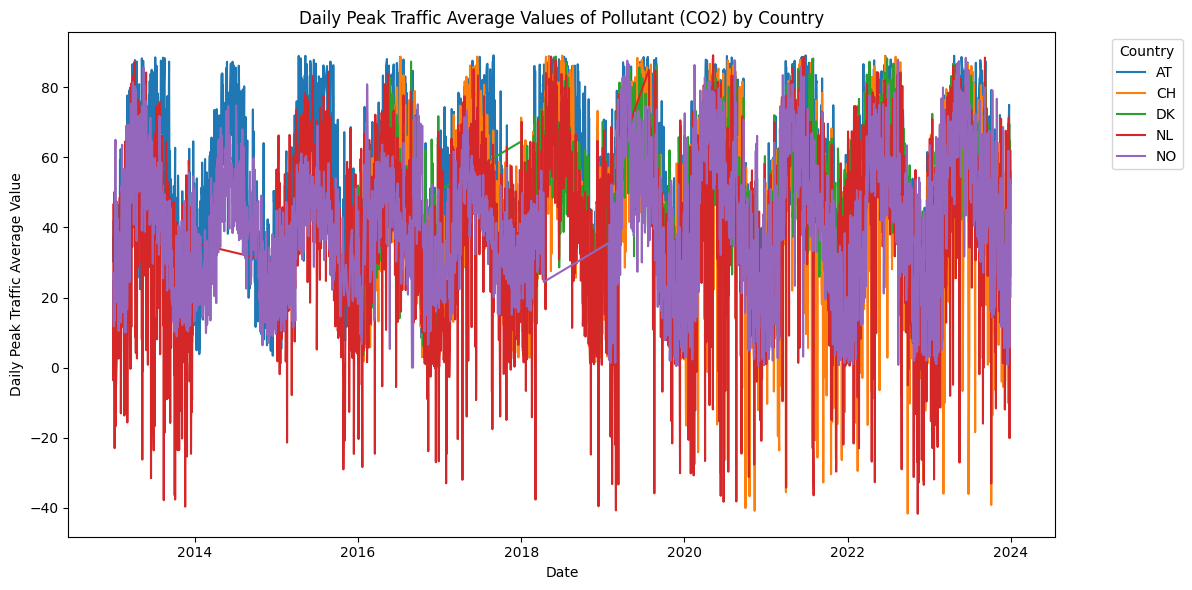

In [ ]:
# Filter data for a specific pollutant (e.g., NO2) for better visualization
pollutant_to_visualize = 7 # CO2
filtered_data = daily_peak_traffic_avg_per_country[daily_peak_traffic_avg_per_country['Pollutant'] == pollutant_to_visualize]

# Plot the data
plt.figure(figsize=(12, 6))
for country in filtered_data['Country'].unique():
    country_data = filtered_data[filtered_data['Country'] == country]
    plt.plot(country_data['Date'], country_data['DailyPeakTrafficAverageValue'], label=country)

plt.title('Daily Peak Traffic Average Values of Pollutant (CO2) by Country')
plt.xlabel('Date')
plt.ylabel('Daily Peak Traffic Average Value')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Per year-analysis

In [ ]:
# Load the annual averages data
aq_annual_averages = pd.read_csv("../data/processed/AQ_annual_averages.csv")

# Display basic info
print("Shape:", aq_annual_averages.shape)
print("Columns:", aq_annual_averages.columns.tolist())
print("\nHead:")
print(aq_annual_averages.head())

# Investigate unique years, countries, and pollutants
years = aq_annual_averages['Year'].unique()
countries = aq_annual_averages['Country'].unique()
pollutants = aq_annual_averages['Pollutant'].unique()

print(f"\nYears in data: {years}")
print(f"Number of countries: {len(countries)}")
print(f"Number of pollutants: {len(pollutants)}")

# For each year, count unique countries and pollutants with annual averages
summary = aq_annual_averages.groupby('Year').agg(
    num_countries=('Country', 'nunique'),
    num_pollutants=('Pollutant', 'nunique')
).reset_index()

print("\nAnnual coverage summary:")
print(summary)

Shape: (308, 9)
Columns: ['Country', 'Pollutant', 'Year', 'AnnualAvg_fullweek_Daytime', 'AnnualAvg_fullweek_RushHour', 'AnnualAvg_weekday_Daytime', 'AnnualAvg_weekday_RushHour', 'AnnualAvg_weekend_Daytime', 'AnnualAvg_weekend_RushHour']

Head:
  Country Pollutant  Year  AnnualAvg_fullweek_Daytime  \
0      AT       CO2  2013                   57.686461   
1      AT       CO2  2014                   55.550252   
2      AT       CO2  2015                   59.145986   
3      AT       CO2  2016                   60.193606   
4      AT       CO2  2017                   63.216454   

   AnnualAvg_fullweek_RushHour  AnnualAvg_weekday_Daytime  \
0                    54.268563                  56.187854   
1                    51.617471                  54.196395   
2                    55.641978                  57.198932   
3                    55.899919                  58.166632   
4                    59.173284                  61.503963   

   AnnualAvg_weekday_RushHour  AnnualAvg_weeke

#### Data coverage over time

/var/folders/c8/hcty8r1j2xj189pdz208fpnr0000gn/T/ipykernel_37916/3773006913.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=aq_annual_averages[aq_annual_averages['Pollutant'] == 'CO2'],


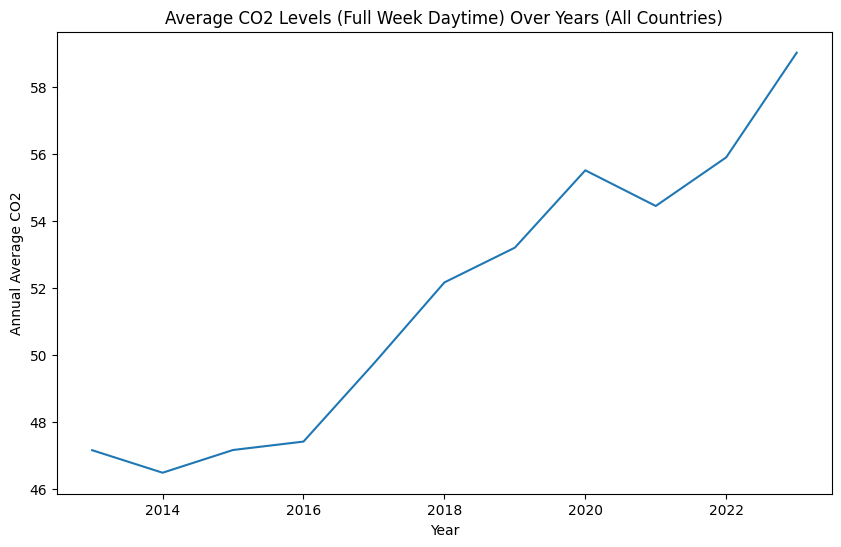

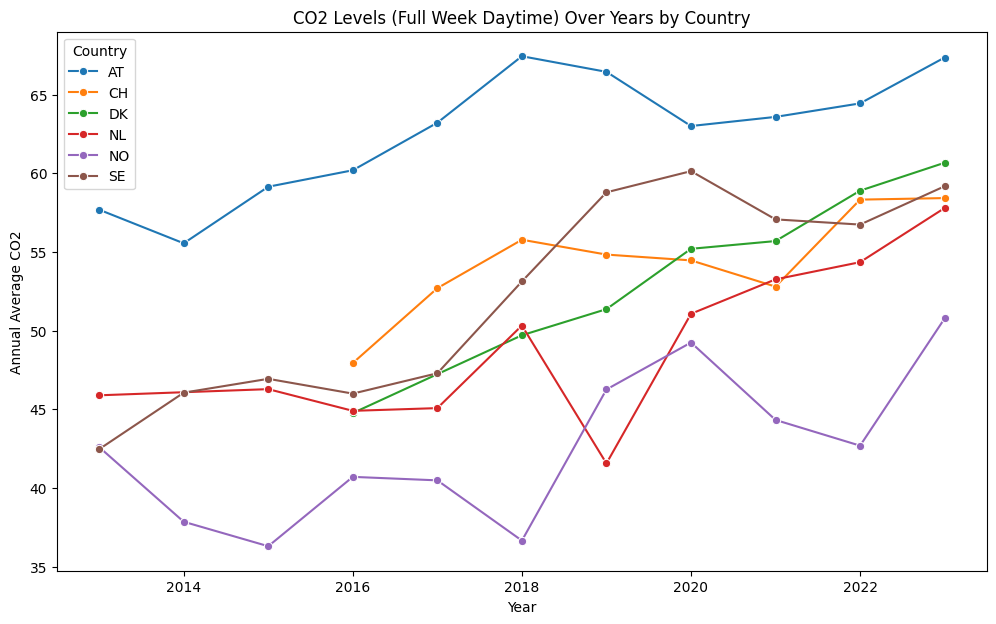

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Plot average full-week daytime levels of CO2 over years across all countries
plt.figure(figsize=(10,6))
sns.lineplot(data=aq_annual_averages[aq_annual_averages['Pollutant'] == 'CO2'],
             x='Year', y='AnnualAvg_fullweek_Daytime', estimator='mean', errorbar=None)
plt.title('Average CO2 Levels (Full Week Daytime) Over Years (All Countries)')
plt.ylabel('Annual Average CO2')
plt.show()

# Plot by country for CO2
plt.figure(figsize=(12,7))
sns.lineplot(data=aq_annual_averages[aq_annual_averages['Pollutant'] == 'CO2'],
             x='Year', y='AnnualAvg_fullweek_Daytime', hue='Country', marker='o')
plt.title('CO2 Levels (Full Week Daytime) Over Years by Country')
plt.ylabel('Annual Average CO2')
plt.legend(title='Country')
plt.show()
fig_path = os.path.join(output_dir, f"aq_avg_annual_weekdaytime_CO2_by_country.png")
plt.savefig(fig_path)
plt.close()
print(f"Saved: {fig_path}")

/var/folders/c8/hcty8r1j2xj189pdz208fpnr0000gn/T/ipykernel_37916/3231665187.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/c8/hcty8r1j2xj189pdz208fpnr0000gn/T/ipykernel_37916/3231665187.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/c8/hcty8r1j2xj189pdz208fpnr0000gn/T/ipykernel_37916/3231665187.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/c8/hcty8r1j2xj189pdz208fpnr0000gn/T/ipykernel_37916/3231665187.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/c8/hcty8r1j2xj189pdz208fpnr0000gn/T/ipykernel_37916/3231665187.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/c8/hcty8r1j2xj189pdz208fpnr

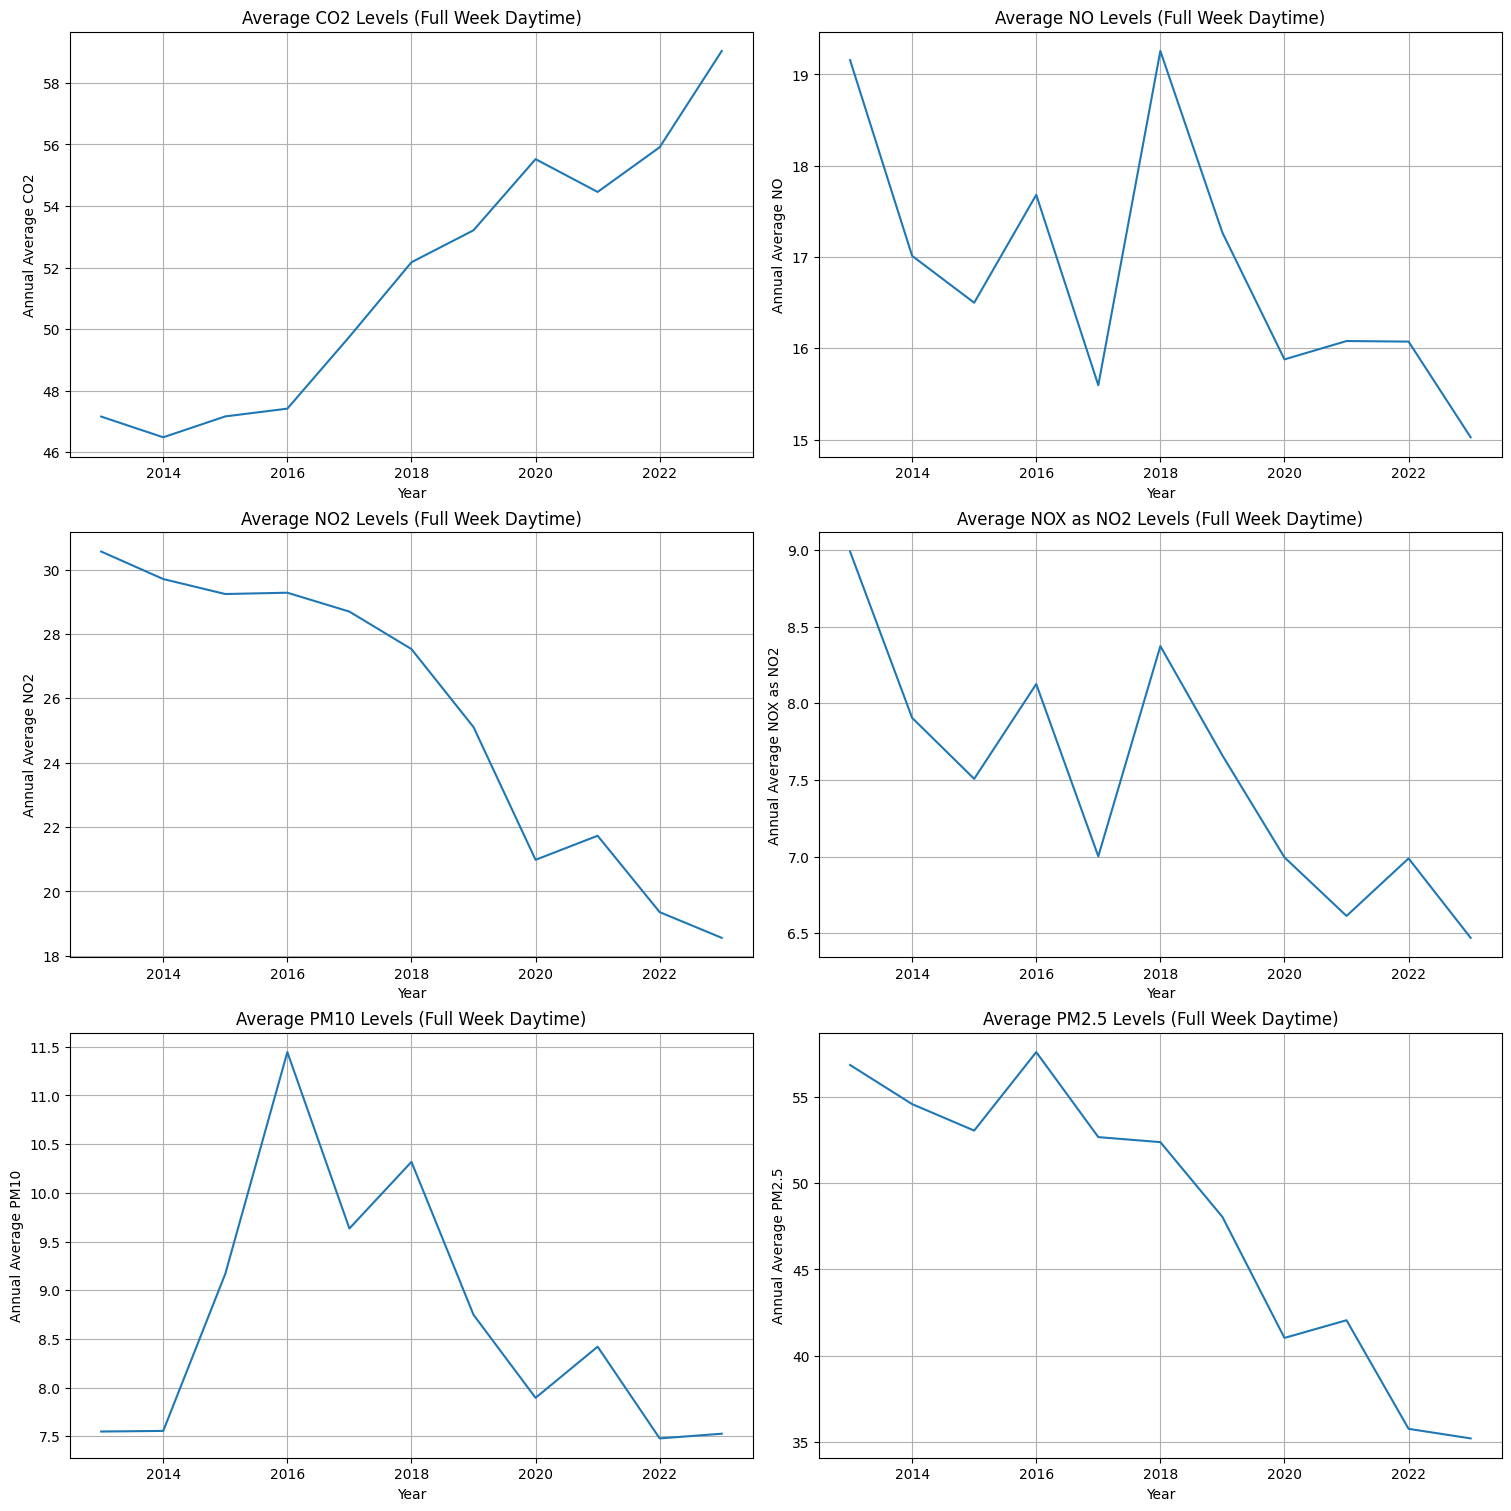

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

# Define the number of rows and columns for the grid
ncols = 2
nrows = (len(unique_pollutants) + ncols - 1) // ncols  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows), constrained_layout=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each pollutant
for ax, pollutant in zip(axes, unique_pollutants):
    # Plot average full-week daytime levels across all countries
    sns.lineplot(
        data=aq_annual_averages[aq_annual_averages['Pollutant'] == pollutant],
        x='Year', y='AnnualAvg_fullweek_Daytime', estimator='mean', errorbar=None, ax=ax
    )
    ax.set_title(f'Average {pollutant} Levels (Full Week Daytime)')
    ax.set_ylabel(f'Annual Average {pollutant}')
    ax.set_xlabel('Year')
    ax.grid(True)
    

# Hide any unused subplots
for ax in axes[len(unique_pollutants):]:
    ax.set_visible(False)

plt.show()

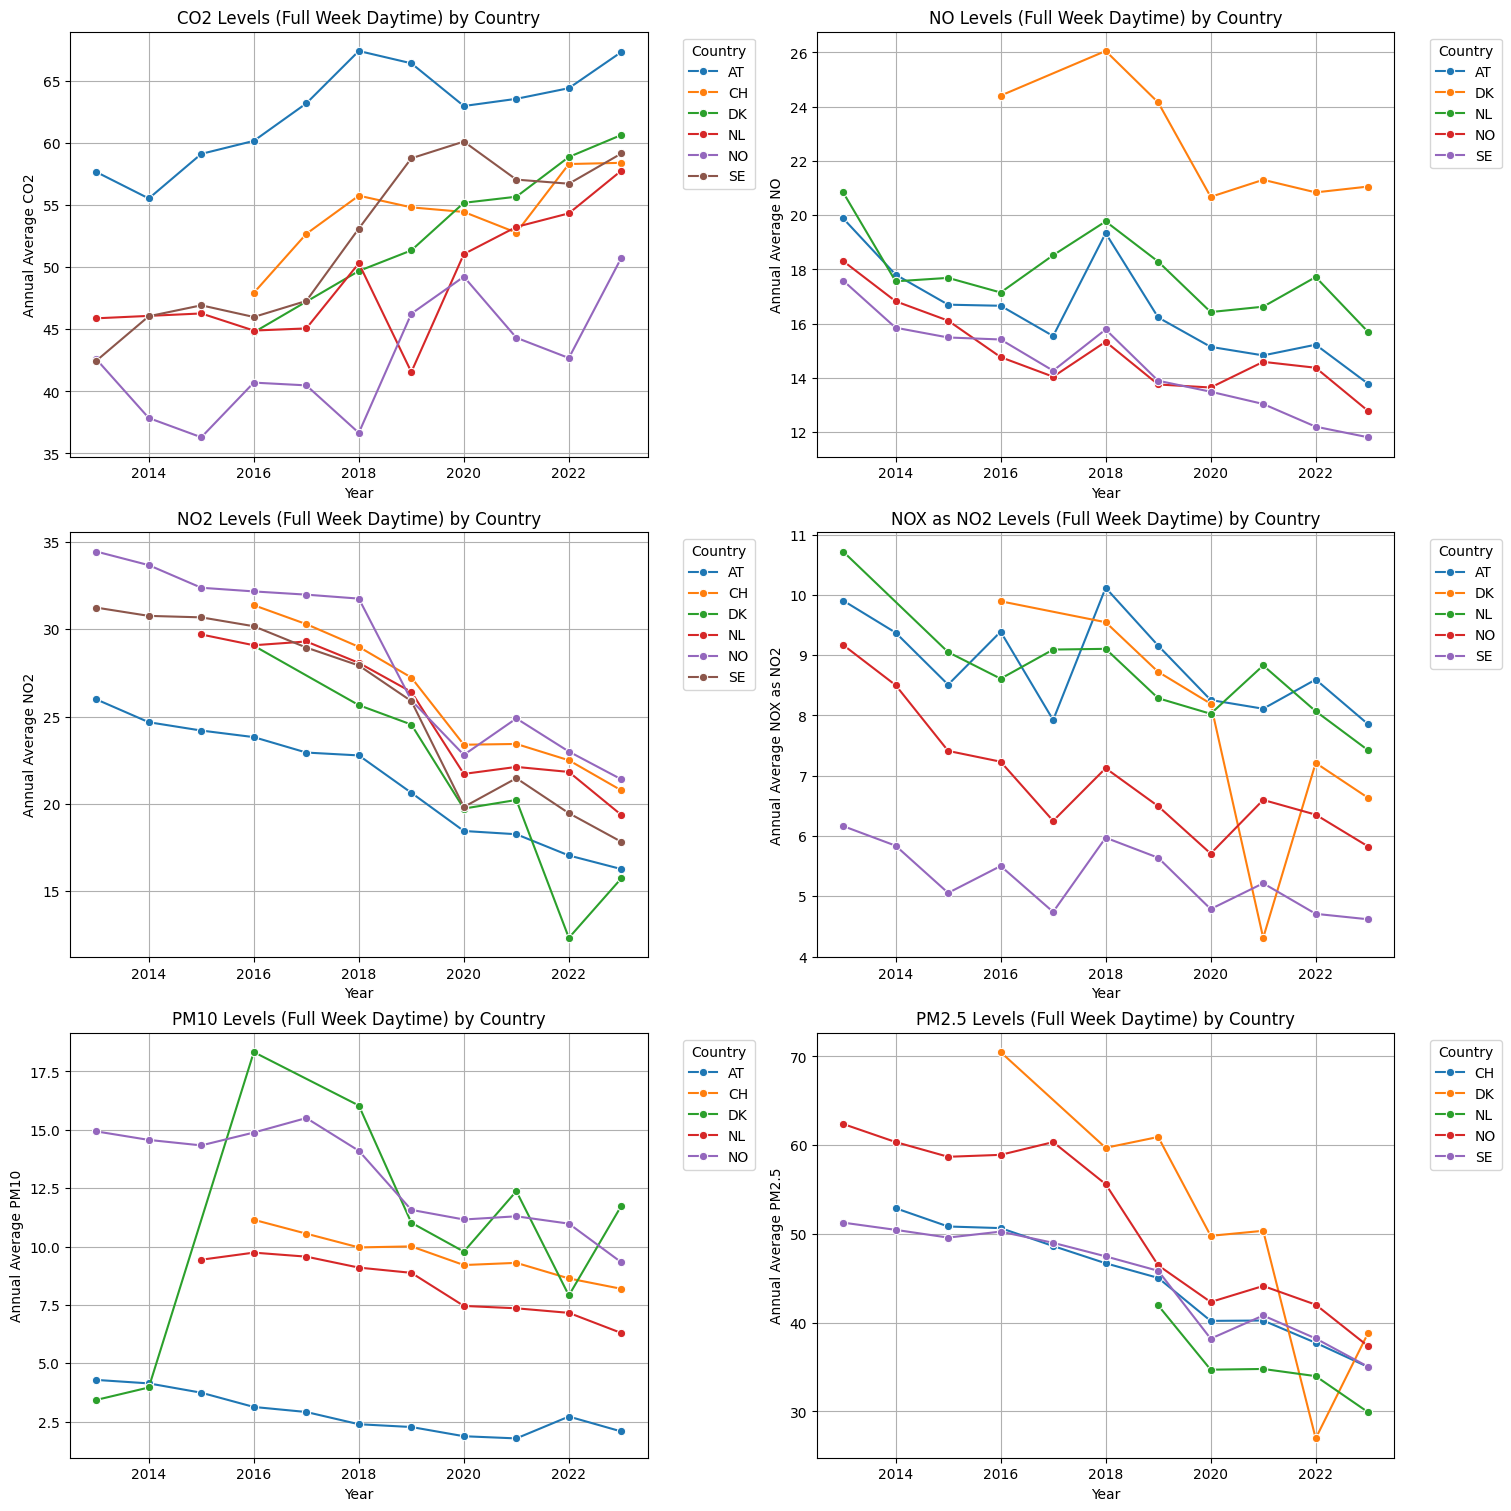

In [ ]:
# Create subplots for country-specific plots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows), constrained_layout=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each pollutant by country
for ax, pollutant in zip(axes, unique_pollutants):
    sns.lineplot(
        data=aq_annual_averages[aq_annual_averages['Pollutant'] == pollutant],
        x='Year', y='AnnualAvg_fullweek_Daytime', hue='Country', marker='o', ax=ax
    )
    ax.set_title(f'{pollutant} Levels (Full Week Daytime) by Country')
    ax.set_ylabel(f'Annual Average {pollutant}')
    ax.set_xlabel('Year')
    ax.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True)
    fig_path = os.path.join(output_dir, f"aq_annnual_avg_{pollutant}_by_country.png")
    plt.savefig(fig_path)
    plt.close()
    print(f"Saved: {fig_path}")

# Hide any unused subplots
for ax in axes[len(unique_pollutants):]:
    ax.set_visible(False)

plt.show()

In [ ]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /


In [ ]:
import os

# Combine data for all pollutants and countries into a single DataFrame
combined_graph_data = aq_annual_averages.pivot_table(
    index=['Year', 'Country'], 
    columns='Pollutant', 
    values='AnnualAvg_fullweek_Daytime'
).reset_index()

# Define the output directory and file path inside the repo folder
output_dir = "results"  # relative path inside your repo root folder
os.makedirs(output_dir, exist_ok=True)  # create folder if it doesn't exist

output_file = os.path.join(output_dir, "country_specific_pollutant_levels.csv")

# Save the combined data to a CSV file
combined_graph_data.to_csv(output_file, index=False)

print(f"Data saved to {output_file}")

Data saved to results/country_specific_pollutant_levels.csv


In [ ]:
import os

# Create the directory if it doesn't exist
output_dir = "../results"
os.makedirs(output_dir, exist_ok=True)

# Combine relevant dataframes into one CSV
combined_data = pd.concat([
    aq_annual_averages,
    country_differences,
    country_ranking,
    summary_table.reset_index()
], axis=1)

# Save the combined data to a CSV file
output_file = os.path.join(output_dir, "graphs_data.csv")
combined_data.to_csv(output_file, index=False)

print(f"Data saved to {output_file}")

OSError: [Errno 30] Read-only file system: '../results'

#### distribution of each pollutant across countries

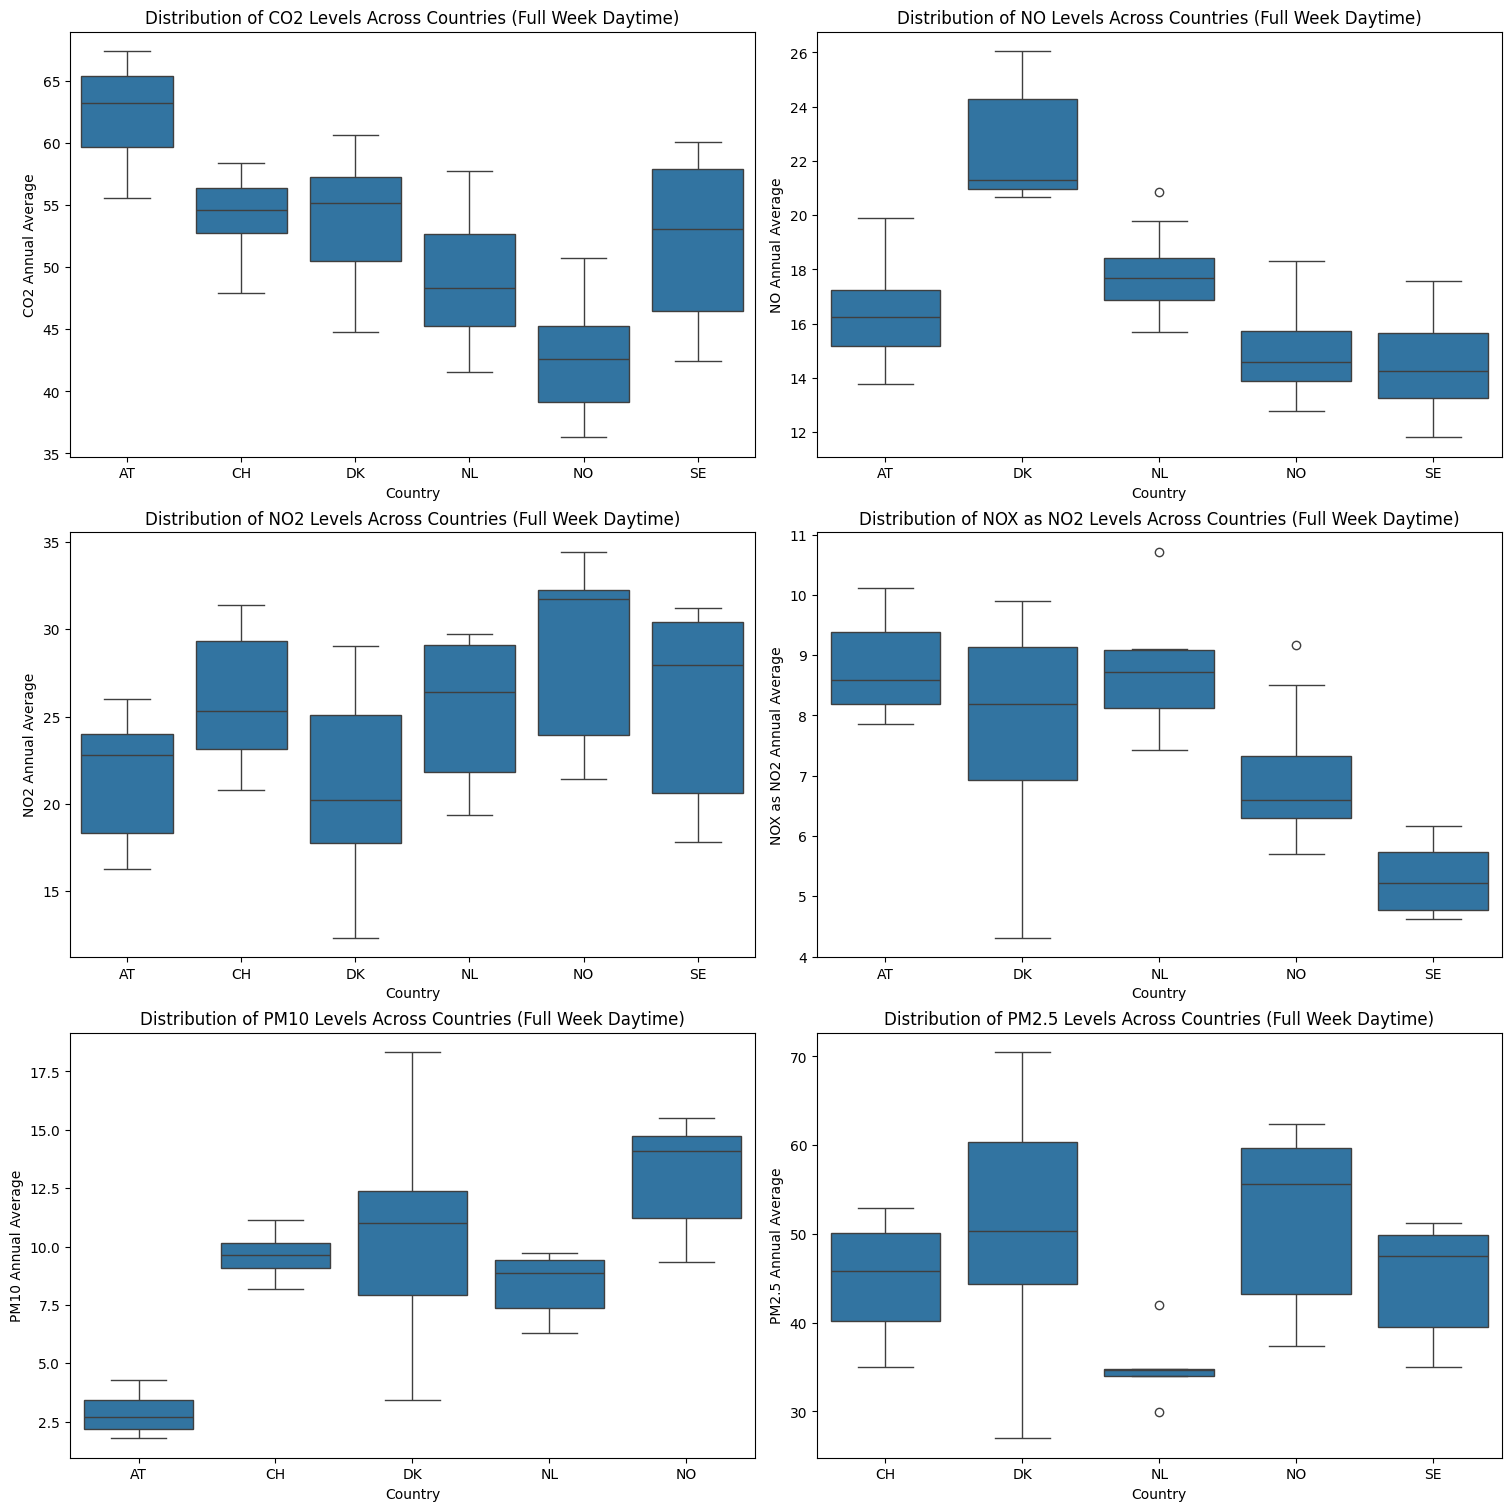

In [ ]:
# Unique pollutants
unique_pollutants = aq_annual_averages['Pollutant'].unique()

# Define the number of rows and columns for the grid
ncols = 2
nrows = (len(unique_pollutants) + ncols - 1) // ncols  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows), constrained_layout=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each pollutant in a separate subplot
for ax, pollutant in zip(axes, unique_pollutants):
    sns.boxplot(
        data=aq_annual_averages[aq_annual_averages['Pollutant'] == pollutant],
        x='Country',
        y='AnnualAvg_fullweek_Daytime',
        ax=ax
    )
    ax.set_title(f'Distribution of {pollutant} Levels Across Countries (Full Week Daytime)')
    ax.set_ylabel(f'{pollutant} Annual Average')
    ax.set_xlabel('Country')
    fig_path = os.path.join(output_dir, f"aq_distribution_of_{pollutant}_by_country.png")
    plt.savefig(fig_path)
    plt.close()
    print(f"Saved: {fig_path}")

# Hide any unused subplots
for ax in axes[len(unique_pollutants):]:
    ax.set_visible(False)

plt.show()

Pollutant        CO2         NO        NO2  NOX as NO2       PM10      PM2.5
Country                                                                     
AT         61.318074  17.222068  23.352438    8.927016   3.256124        NaN
CH         52.948107        NaN  28.350587         NaN  10.453023  48.989195
DK         52.272034  23.859404  22.848134    8.059350  11.320941  55.522849
NL         47.306925  18.363903  27.272967    8.753053   8.956540  38.216216
NO         40.998109  15.832912  31.072513    7.152572  14.091267  56.398829
SE         50.413515  15.234706  28.755081    5.450150        NaN  50.353433


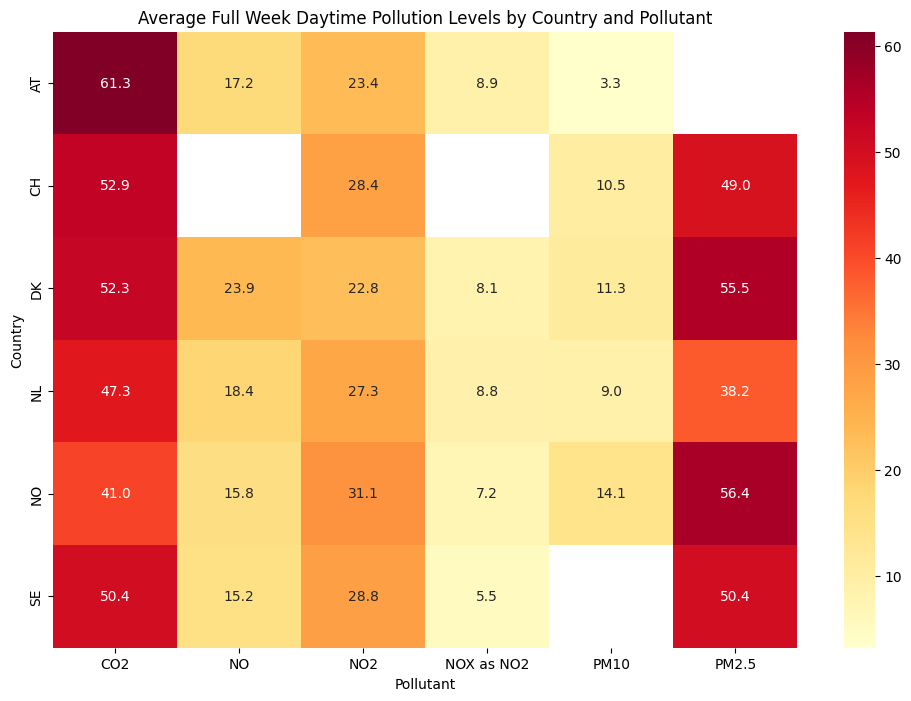

In [ ]:
summary_table = aq_annual_averages.groupby(['Country', 'Pollutant'])['AnnualAvg_weekday_Daytime'].mean().unstack()
print(summary_table)

# Optionally, visualize with heatmap
plt.figure(figsize=(12,8))
sns.heatmap(summary_table, annot=True, cmap='YlOrRd', fmt=".1f")
plt.title('Average Full Week Daytime Pollution Levels by Country and Pollutant')
plt.show()
fig_path = os.path.join(output_dir, f"avg_fullweek_daytime_pollution_by_countryandpollutant.png")
plt.savefig(fig_path)
plt.close()
print(f"Saved: {fig_path}")


Pollutant        CO2         NO        NO2  NOX as NO2       PM10      PM2.5
Country                                                                     
AT         57.332457  17.458105  25.649941    9.103289   3.446366        NaN
CH         48.316484        NaN  30.440717         NaN  10.526641  51.328927
DK         50.196362  23.838751  24.046891    8.237917  11.161715  56.279382
NL         44.494696  18.519768  28.673765    8.703722   8.733087  39.398522
NO         39.250326  15.783280  31.613363    7.243872  13.790159  56.338329
SE         48.151008  15.068764  29.753219    5.520288        NaN  51.340686


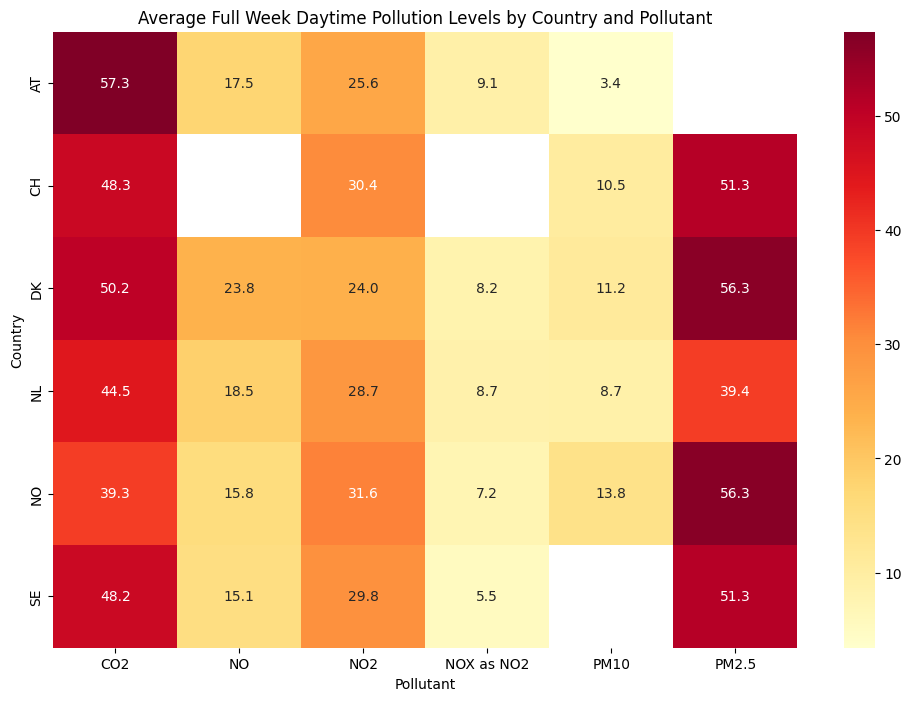

In [ ]:
summary_table = aq_annual_averages.groupby(['Country', 'Pollutant'])['AnnualAvg_weekday_RushHour'].mean().unstack()
print(summary_table)

# Optionally, visualize with heatmap
plt.figure(figsize=(12,8))
sns.heatmap(summary_table, annot=True, cmap='YlOrRd', fmt=".1f")
plt.title('Average Weekday RushHour Pollution Levels by Country and Pollutant')
plt.show()

/var/folders/c8/hcty8r1j2xj189pdz208fpnr0000gn/T/ipykernel_37916/2154441698.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=country_differences, x='Country', y='Difference', palette='viridis')


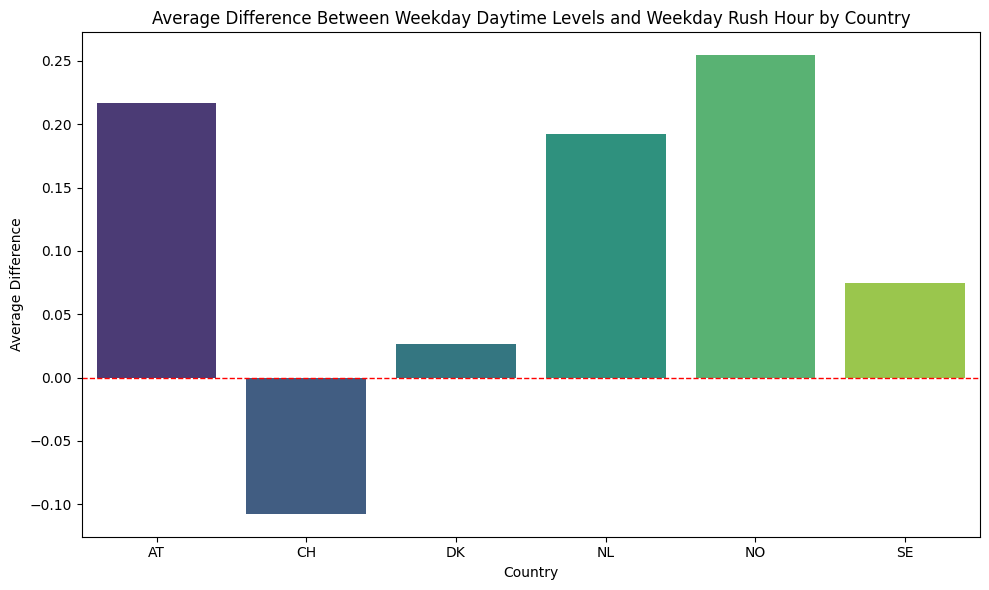

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate the difference between AnnualAvg_weekday_RushHour and AnnualAvg_fullweek_Daytime
aq_annual_averages['Difference'] = aq_annual_averages['AnnualAvg_weekday_Daytime'] - aq_annual_averages['AnnualAvg_weekday_RushHour']

# Group by country and calculate the mean difference
country_differences = aq_annual_averages.groupby('Country')['Difference'].mean().reset_index()

# Plot the differences
plt.figure(figsize=(10, 6))
sns.barplot(data=country_differences, x='Country', y='Difference', palette='viridis')
plt.title('Average Difference Between Weekday Daytime Levels and Weekday Rush Hour by Country')
plt.xlabel('Country')
plt.ylabel('Average Difference')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

---> CH showcase most contribution of pollution due to traffic

In [ ]:
# Calculate the mean of all pollutants for each country
country_ranking = summary_table.mean(axis=1).sort_values(ascending=False).reset_index()
country_ranking.columns = ['Country', 'AveragePollutantLevel']

# Add a rank column
country_ranking['Rank'] = country_ranking['AveragePollutantLevel'].rank(ascending=False).astype(int)

# Display the ranking
print(country_ranking)

  Country  AveragePollutantLevel  Rank
0      CH              35.153192     1
1      SE              29.966793     2
2      DK              28.960170     3
3      NO              27.336555     4
4      NL              24.753927     5
5      AT              22.598032     6


## Seasonal analysis

/var/folders/c8/hcty8r1j2xj189pdz208fpnr0000gn/T/ipykernel_12385/1700334789.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWar

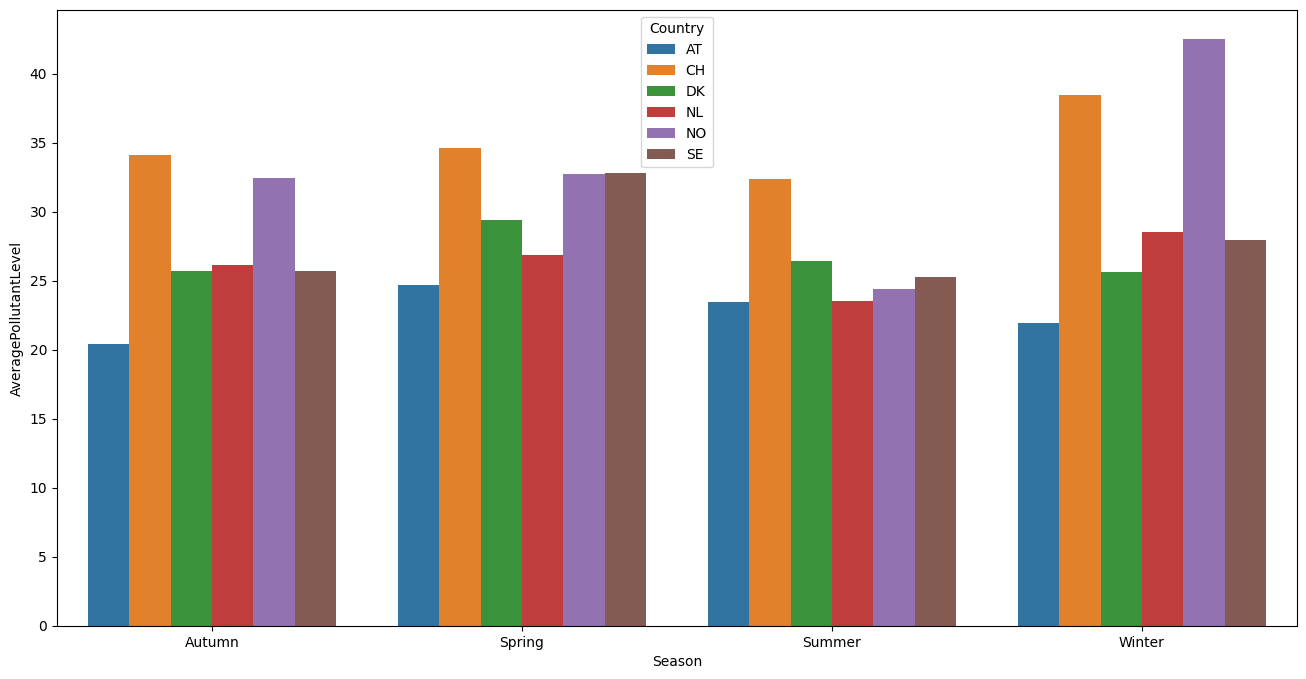

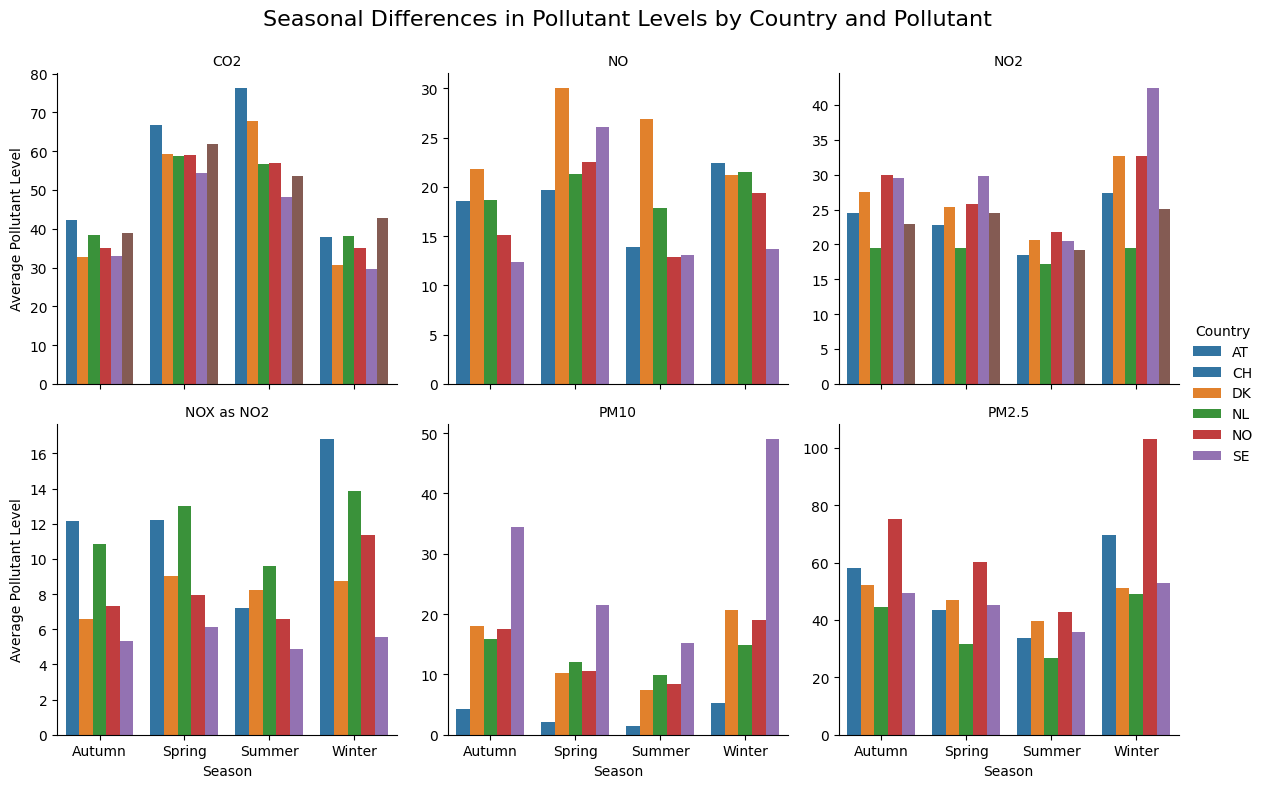

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

# Create a grouped bar plot for seasonal pollutant levels by country
plt.figure(figsize=(16, 8))
sns.barplot(
    data=seasonal_pollutant_levels,
    x='Season',
    y='AveragePollutantLevel',
    hue='Country',
    errorbar=None,
    palette='tab10'
)

# Add pollutant details as a facet grid
g = sns.FacetGrid(seasonal_pollutant_levels, col="Notation", col_wrap=3, height=4, sharey=False)
g.map_dataframe(
    sns.barplot,
    x="Season",
    y="AveragePollutantLevel",
    hue="Country",
    errorbar=None,
    palette="tab10"
)
g.add_legend(title="Country")

# Set titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Season", "Average Pollutant Level")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Seasonal Differences in Pollutant Levels by Country and Pollutant", fontsize=16)

plt.show()

### Country level pollutant correlation

In [ ]:
# Pivot the data to create a wide-format dataframe with pollutants as columns
correlation_data = aq_df_clean.pivot_table(
    index=['Start', 'Country'], 
    columns='Notation', 
    values='Value'
).reset_index()

# Iterate through each country and compute the correlation matrix
correlation_matrices = {}
for country in correlation_data['Country'].unique():
    country_data = correlation_data[correlation_data['Country'] == country].drop(columns=['Start', 'Country'])
    correlation_matrices[country] = country_data.corr()

# Display the correlation matrix for each country
for country, corr_matrix in correlation_matrices.items():
    print(f"Correlation Matrix for {country}:")
    print(corr_matrix)
    print("\n")

Correlation Matrix for AT:
Notation         CO2        NO       NO2  NOX as NO2      PM10  PM2.5
Notation                                                             
CO2         1.000000 -0.269027 -0.421096   -0.420739 -0.397259    NaN
NO         -0.269027  1.000000  0.586356    0.932071  0.352853    NaN
NO2        -0.421096  0.586356  1.000000    0.515315  0.516634    NaN
NOX as NO2 -0.420739  0.932071  0.515315    1.000000  0.335631    NaN
PM10       -0.397259  0.352853  0.516634    0.335631  1.000000    NaN
PM2.5            NaN       NaN       NaN         NaN       NaN    NaN


Correlation Matrix for DK:
Notation         CO2        NO       NO2  NOX as NO2      PM10     PM2.5
Notation                                                                
CO2         1.000000  0.071900 -0.199688   -0.022378 -0.322607 -0.255290
NO          0.071900  1.000000  0.405458    0.344142  0.369086  0.393838
NO2        -0.199688  0.405458  1.000000    0.230521  0.751221  0.918534
NOX as NO2 -0.02237

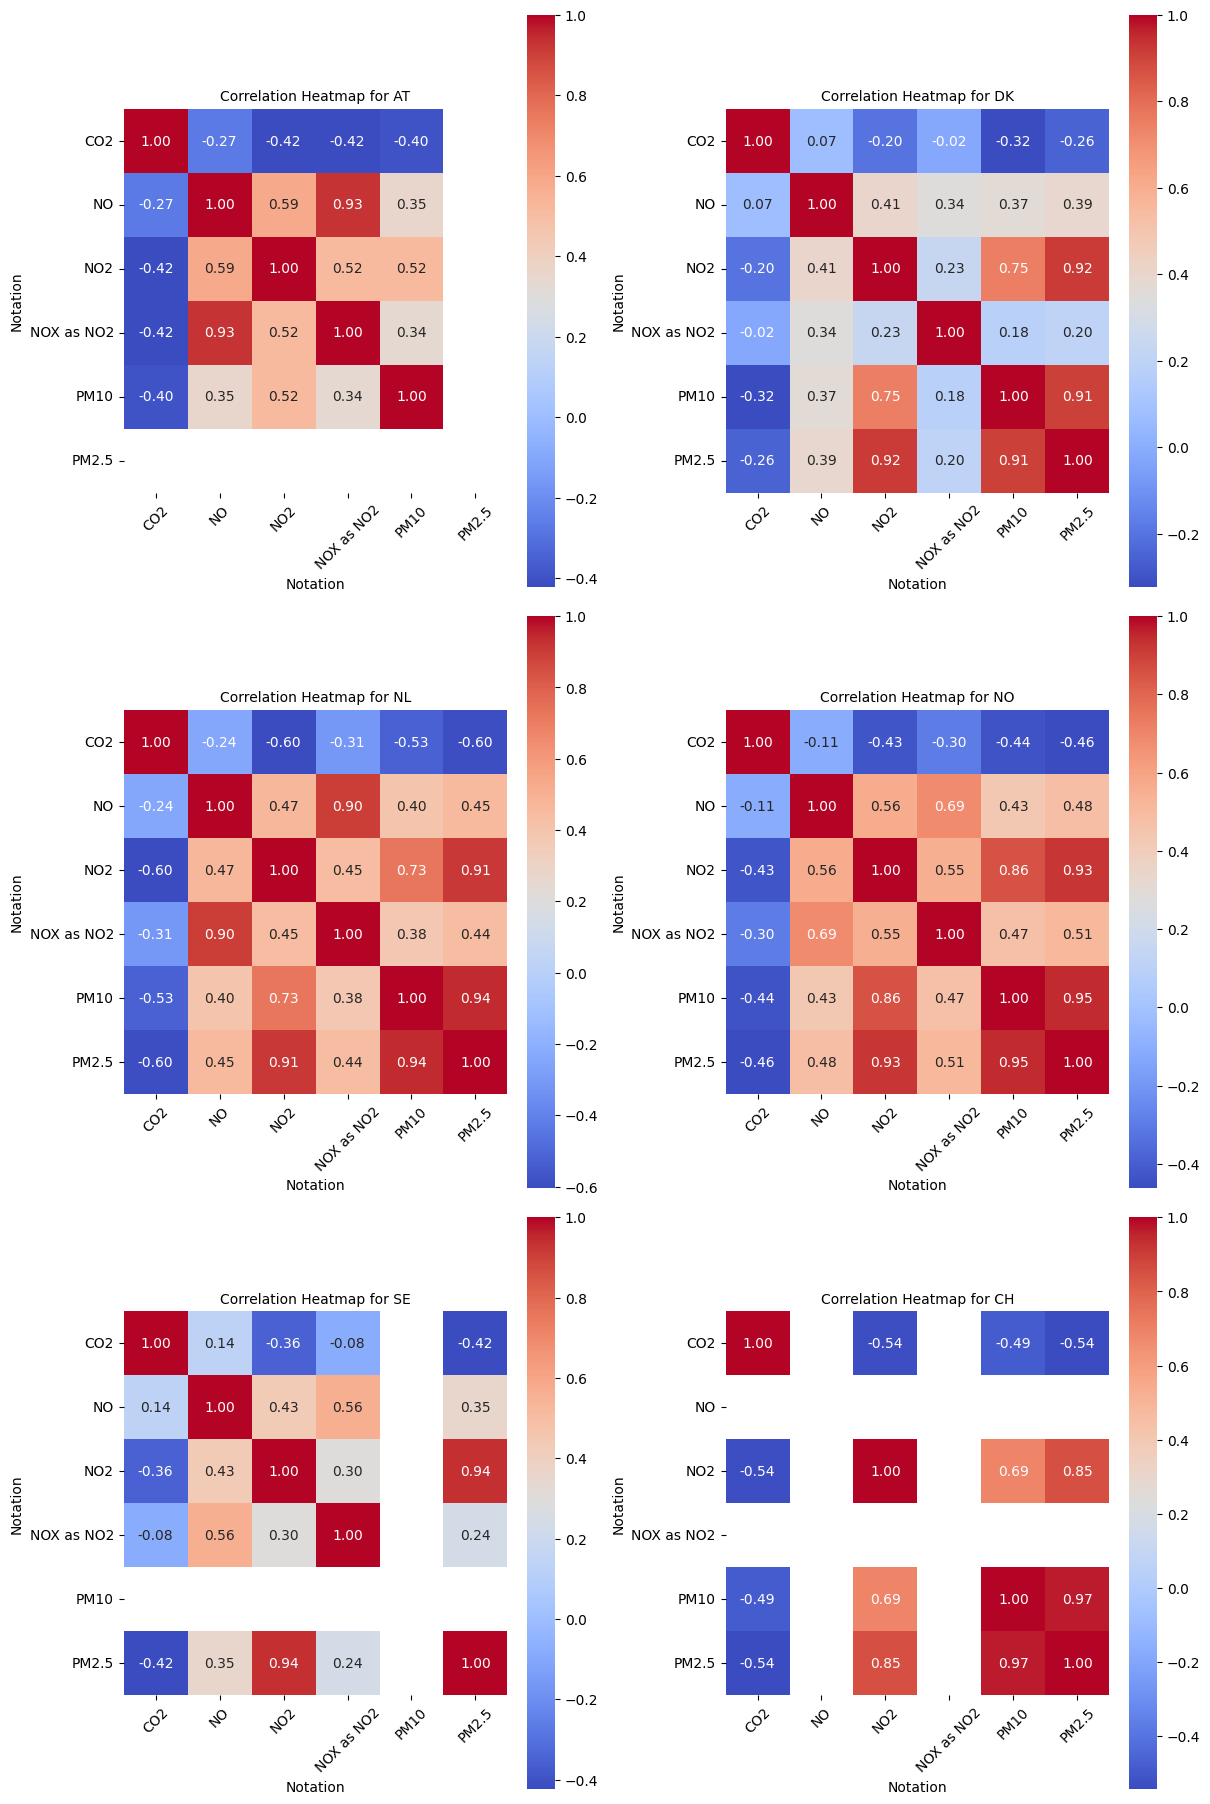

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

# Define the number of columns for the grid
ncols = 2
nrows = (len(correlation_matrices) + ncols - 1) // ncols  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6 * nrows), constrained_layout=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Iterate through each country's correlation matrix and plot a heatmap
for ax, (country, corr_matrix) in zip(axes, correlation_matrices.items()):
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True, ax=ax)
    ax.set_title(f"Correlation Heatmap for {country}", fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

# Hide any unused subplots
for ax in axes[len(correlation_matrices):]:
    ax.set_visible(False)

plt.show()